# Synthetic Data

In [1]:
import os
import shutil
import random
from tqdm import tqdm

# 配置路径
train_root = "/cpfs04/user/hanyujin/rule-gen/eval_datasets/shadow_three_classes_train"
val_root = "/cpfs04/user/hanyujin/rule-gen/eval_datasets/shadow_three_classes_val"
classes = ["0", "1", "2", "3"]  # 假设存在这4个类别目录
random.seed(42)  # 固定随机种子保证可重复性

def move_samples(train_root, val_root, classes, ratio=0.2):
    for cls in tqdm(classes, desc="Processing Classes"):
        # 构建路径
        src_dir = os.path.join(train_root, cls)
        dst_dir = os.path.join(val_root, cls)
        
        # 创建目标目录
        os.makedirs(dst_dir, exist_ok=True)
        
        # 获取所有PNG文件
        files = [f for f in os.listdir(src_dir) if f.lower().endswith(".png")]
        if not files:
            print(f"Warning: No PNG files found in class {cls}")
            continue
            
        # 计算采样数量（至少保留1个在训练集）
        num_total = len(files)
        num_samples = max(1, int(num_total * ratio))
        num_samples = min(num_samples, num_total - 1)  # 保证训练集至少有1个
        
        # 随机采样
        selected_files = random.sample(files, num_samples)
        
        # 移动文件
        for filename in tqdm(selected_files, desc=f"Moving class {cls}", leave=False):
            src_path = os.path.join(src_dir, filename)
            dst_path = os.path.join(dst_dir, filename)
            shutil.move(src_path, dst_path)

if __name__ == "__main__":
    # 验证源路径存在
    if not os.path.exists(train_root):
        raise FileNotFoundError(f"Train directory not found: {train_root}")
    
    # 执行移动操作
    move_samples(train_root, val_root, classes)
    
    print("Operation completed. Verification suggestions:")
    print(f"1. Check file counts with: tree {val_root}")
    print(f"2. Verify random samples with: ls {os.path.join(val_root, '0')} | head -n 5")

Processing Classes: 100%|██████████| 4/4 [01:27<00:00, 21.80s/it]

Operation completed. Verification suggestions:
1. Check file counts with: tree /cpfs04/user/hanyujin/rule-gen/eval_datasets/shadow_three_classes_val
2. Verify random samples with: ls /cpfs04/user/hanyujin/rule-gen/eval_datasets/shadow_three_classes_val/0 | head -n 5


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
import random
import cv2

def random_color_from_hsv_range(hsv_range):
    h = random.uniform(hsv_range[0][0], hsv_range[0][1])
    s = random.uniform(hsv_range[1][0], hsv_range[1][1])
    v = random.uniform(hsv_range[2][0], hsv_range[2][1])
    return cv2.cvtColor(np.uint8([[[h, s, v]]]), cv2.COLOR_HSV2RGB)[0][0]

def create_sun_shadow_image(pole_height, sun_x, image_size=64, is_real=True):
    # 通过调整figsize来控制输出图像的实际尺寸
    fig, ax = plt.subplots(figsize=(image_size / 100, image_size / 100))  # 设置大小为64x64像素
    ax.set_xlim(0, image_size)
    ax.set_ylim(0, image_size)
    ax.set_aspect('equal')
    ax.axis('off')

    ground_level = image_size * 0.1
    pole_base_x = image_size // 2
    pole_width = image_size * 0.12  

    sun_height = np.clip(pole_height * 2, image_size * 0.3, image_size * 0.8)

    sun_distance = sun_x - pole_base_x
    shadow_length = pole_height * abs(sun_distance) / (sun_height - pole_height)

    if is_real:
        shadow_direction = -1 if sun_distance > 0 else 1
    else:
        shadow_direction = 1 if sun_distance > 0 else -1


    sun_hsv_range = [(0, 30), (100, 255), (200, 255)]  # 黄色系
    pole_hsv_range = [(90, 150), (100, 255), (100, 255)]  # 蓝绿色系
    shadow_hsv_range = [(0, 180), (0, 50), (50, 150)]  # 黑色、棕色、灰色系

    sun_color = random_color_from_hsv_range(sun_hsv_range)
    pole_color = random_color_from_hsv_range(pole_hsv_range)
    shadow_color = random_color_from_hsv_range(shadow_hsv_range)

    # shadow
    ax.add_patch(plt.Rectangle((pole_base_x, ground_level - image_size * 0.08), 
                               shadow_length * shadow_direction, image_size * 0.08, facecolor=shadow_color/255.0))  # 调整影子的高度

    # pole
    ax.add_patch(plt.Rectangle((pole_base_x - pole_width/2, ground_level), 
                               pole_width, pole_height, facecolor=pole_color/255.0))

    # sun
    sun_radius = image_size * 0.1
    sun_y = sun_height + ground_level
    ax.add_patch(plt.Circle((sun_x, sun_y), sun_radius, facecolor=sun_color/255.0))

    return fig, (sun_color, pole_color, shadow_color)

def generate_images(base_path, min_pole_height, max_pole_height, image_size=64, images_per_class=1000):
    os.makedirs(base_path, exist_ok=True)
    
    far_distances = [(0.00 * image_size, 0.2 * image_size), (0.8 * image_size, 1.0 * image_size)]
    near_distances = [(0.3 * image_size, 0.5 * image_size), (0.5 * image_size, 0.7 * image_size)]
    classes = [
       ('l', 'f', 'd'),('l', 'n', 'd'),
        ('r', 'f', 'd'), ('r', 'n', 'd')
    ]

    images = []
    for direction, distance, real in classes:
        folder_name = f"{direction}_{distance}_{real}"
        folder_path = os.path.join(base_path, folder_name)
        os.makedirs(folder_path, exist_ok=True)

        is_real = (real == 'd')
        
        if distance == 'f':
            distance_ranges = far_distances
        else:
            distance_ranges = near_distances

        for j in tqdm(range(images_per_class), desc=f"Generating images for {folder_name}"):

            if direction == 'l':
                distance_range = distance_ranges[0]  
            else:
                distance_range = distance_ranges[1]  
            
            sun_x = np.random.uniform(distance_range[0], distance_range[1])

            pole_height = np.random.uniform(min_pole_height, max_pole_height)
            fig, colors = create_sun_shadow_image(pole_height, sun_x, image_size, is_real)
            
            image_path = os.path.join(folder_path, f"{j+1}.png")
            fig.savefig(image_path, bbox_inches='tight', pad_inches=0, dpi=100)  # 使用dpi控制图像分辨率
            plt.close(fig)

            if j < 8:  
                images.append((image_path, folder_name))

    print("Image generation complete.")
    return images

image_size = 64
images_per_class = 12500
min_pole_height = image_size * 0.2
max_pole_height = image_size * 0.4
base_path = f"/cpfs04/user/hanyujin/causal-dm/synthetic_data_number{images_per_class*4}_size{image_size}"
images = generate_images(base_path, min_pole_height, max_pole_height, image_size, images_per_class=images_per_class)

Generating images for l_f_d:   0%|          | 14/12500 [00:00<05:27, 38.09it/s]

Generating images for r_n_d: 100%|██████████| 12500/12500 [05:49<00:00, 35.77it/s] 

Image generation complete.


In [39]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
import random
import cv2

def random_color_from_hsv_range(hsv_range):
    h = random.uniform(hsv_range[0][0], hsv_range[0][1])
    s = random.uniform(hsv_range[1][0], hsv_range[1][1])
    v = random.uniform(hsv_range[2][0], hsv_range[2][1])
    return cv2.cvtColor(np.uint8([[[h, s, v]]]), cv2.COLOR_HSV2RGB)[0][0]

def create_sun_shadow_image(pole_height, sun_x, image_size=64, is_real=True):
    # 通过调整figsize来控制输出图像的实际尺寸
    fig, ax = plt.subplots(figsize=(image_size / 100, image_size / 100))  # 设置大小为64x64像素
    ax.set_xlim(0, image_size)
    ax.set_ylim(0, image_size)
    ax.set_aspect('equal')
    ax.axis('off')

    ground_level = image_size * 0.1
    pole_base_x = image_size // 2
    pole_width = image_size * 0.12  

    sun_height = np.clip(pole_height * 2, image_size * 0.3, image_size * 0.8)

    sun_distance = sun_x - pole_base_x
    shadow_length = pole_height * abs(sun_distance) / (sun_height - pole_height)

    if is_real:
        shadow_direction = -1 if sun_distance > 0 else 1
    else:
        shadow_direction = 1 if sun_distance > 0 else -1


    sun_hsv_range = [(0, 30), (100, 255), (200, 255)]  # 黄色系
    pole_hsv_range = [(90, 150), (100, 255), (100, 255)]  # 蓝绿色系
    shadow_hsv_range = [(0, 180), (0, 50), (50, 150)]  # 黑色、棕色、灰色系

    sun_color = random_color_from_hsv_range(sun_hsv_range)
    pole_color = random_color_from_hsv_range(pole_hsv_range)
    shadow_color = random_color_from_hsv_range(shadow_hsv_range)

    # shadow
    ax.add_patch(plt.Rectangle((pole_base_x, ground_level - image_size * 0.08), 
                               shadow_length * shadow_direction, image_size * 0.08, facecolor=shadow_color/255.0))  # 调整影子的高度

    # pole
    ax.add_patch(plt.Rectangle((pole_base_x - pole_width/2, ground_level), 
                               pole_width, pole_height, facecolor=pole_color/255.0))

    # sun
    sun_radius = image_size * 0.1
    sun_y = sun_height + ground_level
    ax.add_patch(plt.Circle((sun_x, sun_y), sun_radius, facecolor=sun_color/255.0))

    return fig, (sun_color, pole_color, shadow_color)

def generate_images(base_path, min_pole_height, max_pole_height, image_size=64, images_per_class=1000):
    os.makedirs(base_path, exist_ok=True)  # 创建统一存储目录
    
    far_distances = [(0.00 * image_size, 0.2 * image_size), (0.8 * image_size, 1.0 * image_size)]
    near_distances = [(0.3 * image_size, 0.5 * image_size), (0.5 * image_size, 0.7 * image_size)]
    classes = [
        ('l', 'f', 's'),
        ('r', 'f', 's')
    ]

    images = []
    for direction, distance, real in classes:
        is_real = (real == 'd')
        
        # 确定距离范围
        if distance == 'f':
            distance_ranges = far_distances
        else:
            distance_ranges = near_distances

        # 确定方向对应的具体距离区间
        if direction == 'l':
            distance_range = distance_ranges[0]
        else:
            distance_range = distance_ranges[1]

        for j in tqdm(range(images_per_class), desc=f"Generating {direction}-{distance}-{real}"):
            # 生成太阳位置和旗杆高度
            sun_x = np.random.uniform(distance_range[0], distance_range[1])
            pole_height = np.random.uniform(min_pole_height, max_pole_height)
            
            # 创建图像
            fig, colors = create_sun_shadow_image(pole_height, sun_x, image_size, is_real)
            
            # 生成唯一文件名
            filename = f"{direction}_{distance}_{real}_{j+1}.png"
            image_path = os.path.join(base_path, filename)
            
            # 保存图像
            fig.savefig(image_path, bbox_inches='tight', pad_inches=0, dpi=100)
            plt.close(fig)

            # 记录示例图像路径
            if j < 8:
                images.append((image_path, f"{direction}_{distance}_{real}"))

    print("Image generation complete.")
    return images

image_size = 64
images_per_class = 5000
min_pole_height = image_size * 0.2
max_pole_height = image_size * 0.4
base_path = f"/cpfs04/user/hanyujin/rule-gen/datasets/shadow_three_classes/3"
images = generate_images(base_path, min_pole_height, max_pole_height, image_size, images_per_class=images_per_class)

Generating l-f-s:   0%|          | 0/5000 [00:00<?, ?it/s]

Generating r-f-s: 100%|██████████| 5000/5000 [02:08<00:00, 38.94it/s]

Image generation complete.


In [36]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
import random
import cv2

def random_color_from_hsv_range(hsv_range):
    h = random.uniform(hsv_range[0][0], hsv_range[0][1])
    s = random.uniform(hsv_range[1][0], hsv_range[1][1])
    v = random.uniform(hsv_range[2][0], hsv_range[2][1])
    return cv2.cvtColor(np.uint8([[[h, s, v]]]), cv2.COLOR_HSV2RGB)[0][0]

def create_sun_shadow_image(pole_height, sun_x, image_size=64, is_real=True, shadow_scale=None):
    # 通过调整figsize来控制输出图像的实际尺寸
    fig, ax = plt.subplots(figsize=(image_size / 100, image_size / 100))  # 设置大小为64x64像素
    ax.set_xlim(0, image_size)
    ax.set_ylim(0, image_size)
    ax.set_aspect('equal')
    ax.axis('off')

    ground_level = image_size * 0.1
    pole_base_x = image_size // 2
    pole_width = image_size * 0.12  

    sun_height = np.clip(pole_height * 2, image_size * 0.3, image_size * 0.8)

    sun_distance = sun_x - pole_base_x
    
    # 影子长度计算逻辑
    base_shadow_length = pole_height * abs(sun_distance) / (sun_height - pole_height)
    
    # 添加异常缩放
    # if shadow_scale and not is_real:
    shadow_length = base_shadow_length * shadow_scale
    # else:
    #     shadow_length = base_shadow_length

    if is_real:
        shadow_direction = -1 if sun_distance > 0 else 1
    else:
        shadow_direction = 1 if sun_distance > 0 else -1

    sun_hsv_range = [(0, 30), (100, 255), (200, 255)]  # 黄色系
    pole_hsv_range = [(90, 150), (100, 255), (100, 255)]  # 蓝绿色系
    shadow_hsv_range = [(0, 180), (0, 50), (50, 150)]  # 黑色、棕色、灰色系

    sun_color = random_color_from_hsv_range(sun_hsv_range)
    pole_color = random_color_from_hsv_range(pole_hsv_range)
    shadow_color = random_color_from_hsv_range(shadow_hsv_range)

    # shadow
    ax.add_patch(plt.Rectangle((pole_base_x, ground_level - image_size * 0.08), 
                               shadow_length * shadow_direction, image_size * 0.08, facecolor=shadow_color/255.0))

    # pole
    ax.add_patch(plt.Rectangle((pole_base_x - pole_width/2, ground_level), 
                               pole_width, pole_height, facecolor=pole_color/255.0))

    # sun
    sun_radius = image_size * 0.1
    sun_y = sun_height + ground_level
    ax.add_patch(plt.Circle((sun_x, sun_y), sun_radius, facecolor=sun_color/255.0))

    return fig, (sun_color, pole_color, shadow_color)

def generate_images(base_path, min_pole_height, max_pole_height, image_size=64, 
                   images_per_class=1000, abnormal_ratio=1):
    os.makedirs(base_path, exist_ok=True)
    
    far_distances = [(0.00 * image_size, 0.2 * image_size), (0.8 * image_size, 1.0 * image_size)]
    near_distances = [(0.3 * image_size, 0.5 * image_size), (0.5 * image_size, 0.7 * image_size)]
    classes = [
        ('l', 'f', 'd'),
        ('r', 'f', 'd')
    ]

    images = []
    for direction, distance, real in classes:
        is_real_flag = (real == 'd')
        
        # 计算正常和异常数量
        normal_count = int(images_per_class * (1 - abnormal_ratio))
        abnormal_count = images_per_class - normal_count
        
        if distance == 'f':
            distance_ranges = far_distances
        else:
            distance_ranges = near_distances

        if direction == 'l':
            distance_range = distance_ranges[0]
        else:
            distance_range = distance_ranges[1]

        # 生成正常图片
        for j in tqdm(range(normal_count), desc=f"Normal {direction}-{distance}-{real}"):
            sun_x = np.random.uniform(distance_range[0], distance_range[1])
            pole_height = np.random.uniform(min_pole_height, max_pole_height)
            
            fig, colors = create_sun_shadow_image(pole_height, sun_x, image_size, is_real_flag)
            
            filename = f"normal_{direction}_{distance}_{real}_{j+1}.png"
            image_path = os.path.join(base_path, filename)
            fig.savefig(image_path, bbox_inches='tight', pad_inches=0, dpi=100)
            plt.close(fig)

            if j < 8:
                images.append((image_path, "normal"))

        # 生成异常图片（随机拉长影子）
        for j in tqdm(range(abnormal_count), desc=f"Abnormal {direction}-{distance}-{real}"):
            sun_x = np.random.uniform(distance_range[0], distance_range[1])
            pole_height = np.random.uniform(min_pole_height, max_pole_height)
            
            # 随机生成缩放系数（1.5-3倍）
            shadow_scale = random.uniform(0.3, 0.5)
            
            fig, colors = create_sun_shadow_image(
                pole_height, sun_x, image_size,
                is_real=is_real_flag,  # 强制标记为异常
                shadow_scale=shadow_scale
            )
            
            filename = f"abnormal_random_{direction}_{distance}_{real}_{j+1}.png"
            image_path = os.path.join(base_path, filename)
            fig.savefig(image_path, bbox_inches='tight', pad_inches=0, dpi=100)
            plt.close(fig)

            if j < 8:
                images.append((image_path, "abnormal_random"))

    print(f"生成完成，异常图片占比：{abnormal_ratio*100}%")
    return images

image_size = 64
images_per_class = 5000
min_pole_height = image_size * 0.2
max_pole_height = image_size * 0.4
base_path = f"/cpfs04/user/hanyujin/rule-gen/datasets/shadow_three_classes/2"
images = generate_images(base_path, min_pole_height, max_pole_height, 
                        image_size=image_size, 
                        images_per_class=images_per_class,
                        abnormal_ratio=1)

Normal l-f-d: 0it [00:00, ?it/s]
Abnormal l-f-d: 100%|██████████| 5000/5000 [02:19<00:00, 35.95it/s]
Normal r-f-d: 0it [00:00, ?it/s]
Abnormal r-f-d: 100%|██████████| 5000/5000 [02:08<00:00, 39.00it/s]

生成完成，异常图片占比：100%


# Evaluation

In [35]:
# Enhanced
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os
import glob
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def analyze_image(image_path, target_size=128, data_name = 'train'):
    img = cv2.imread(image_path)
    if img is None:
        return None
    
    img = cv2.resize(img, (target_size, target_size), interpolation=cv2.INTER_AREA)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    if data_name == 'gen':
        sun_lower = np.array([0, 50, 200])
        sun_upper = np.array([60, 255, 255])
        pole_lower = np.array([90, 50, 50])
        pole_upper = np.array([150, 255, 255])
        shadow_lower = np.array([0, 0, 0])
        shadow_upper = np.array([180, 150, 220])
    
    elif data_name == 'train':
        sun_lower = np.array([0, 100, 200])
        sun_upper = np.array([30, 255, 255])
        pole_lower = np.array([90, 100, 100])
        pole_upper = np.array([150, 255, 255])
        shadow_lower = np.array([0, 0, 50])
        shadow_upper = np.array([180, 50, 150])

    sun_mask = cv2.inRange(hsv, sun_lower, sun_upper)
    pole_mask = cv2.inRange(hsv, pole_lower, pole_upper)
    shadow_mask = cv2.inRange(hsv, shadow_lower, shadow_upper)

    sun_contours, _ = cv2.findContours(sun_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    pole_contours, _ = cv2.findContours(pole_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    shadow_contours, _ = cv2.findContours(shadow_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not sun_contours or not shadow_contours or not pole_contours:
        return None

    try:
        sun_contour = max(sun_contours, key=cv2.contourArea)
        sun_moments = cv2.moments(sun_contour)
        sun_cx = int(sun_moments['m10'] / sun_moments['m00']) if sun_moments['m00'] != 0 else 0
        sun_cy = int(sun_moments['m01'] / sun_moments['m00']) if sun_moments['m00'] != 0 else 0

        pole_contour = max(pole_contours, key=cv2.contourArea)
        pole_moments = cv2.moments(pole_contour)
        pole_cx = int(pole_moments['m10'] / pole_moments['m00']) if pole_moments['m00'] != 0 else 0
        pole_cy = int(pole_moments['m01'] / pole_moments['m00']) if pole_moments['m00'] != 0 else 0
        pole_top = tuple(pole_contour[pole_contour[:, :, 1].argmin()][0])
        pole_bottom = tuple(pole_contour[pole_contour[:, :, 1].argmax()][0])

        shadow_contour = max(shadow_contours, key=cv2.contourArea)
        shadow_left = tuple(shadow_contour[shadow_contour[:, :, 0].argmin()][0])
        shadow_right = tuple(shadow_contour[shadow_contour[:, :, 0].argmax()][0])

        s1 = abs(sun_cx - pole_cx)
        s2 = abs(sun_cy - pole_top[1])

        if pole_top[0] == pole_bottom[0] or abs(pole_bottom[0] - pole_top[0]) <= target_size * 0.01:
            shadow_tail = shadow_right if abs(shadow_right[0] - pole_top[0]) > abs(shadow_left[0] - pole_top[0]) else shadow_left
        else:
            distances = [
                    (abs(shadow_left[0] - pole_top[0]), shadow_left),
                    (abs(shadow_right[0] - pole_top[0]), shadow_right),
                    (abs(pole_bottom[0] - pole_top[0]), pole_bottom)
            ]
            _, shadow_tail = max(distances, key=lambda x: x[0])

        l1 = abs(shadow_tail[0] - pole_top[0])
        l2 = abs(pole_top[1] - shadow_tail[1])

        if l2 == 0 or s2 == 0:
            return None

 
        a = ((s1 * l2) / (target_size ** 2))
        b = (s2 * l1) / (target_size ** 2)

        # if (b > 0.05 ) and (a < 0.02 ) :
        if (b / a - 1 > 1 ) :
            obs = os.path.splitext(os.path.basename(image_path))[0]
        else:
            obs = 'skip'
        cv2.line(img, (sun_cx, sun_cy), (pole_cx, sun_cy), (0, 255, 0), 2)  # s1
        cv2.line(img, (sun_cx, sun_cy), (sun_cx, pole_top[1]), (255, 0, 0), 2)  # s2
        cv2.line(img, (pole_top[0], shadow_tail[1]), (shadow_tail[0], shadow_tail[1]), (0, 0, 255), 2)  # l1
        cv2.line(img, (pole_top[0], pole_top[1]), (pole_top[0], shadow_tail[1]), (255, 255, 0), 2)  # l2

        cv2.putText(img, 's1', (pole_cx, sun_cy - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        cv2.putText(img, 's2', (sun_cx + 5, (sun_cy + pole_top[1]) // 2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        cv2.putText(img, 'l1', ((pole_top[0] + shadow_tail[0]) // 2, shadow_tail[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
        cv2.putText(img, 'l2', (pole_top[0] + 5, (pole_top[1] + shadow_tail[1]) // 2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)
        img = img.astype(np.uint8) 
        return img,(s1 * l2) / (target_size ** 2), (s2 * l1) / (target_size ** 2), ((s2 * l1) / (s1 * l2 + 1e-4) - 1), obs
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")
        return None



# def process_folder(folder_path,target_size, data_name):
#     txt_files = glob.glob(os.path.join(folder_path, "('*', '*', 'd')_files.txt"))
#     data = defaultdict(list)
#     ratios = []
#     obs = []

#     if txt_files:
#         for txt_file in txt_files:
#             category = os.path.basename(txt_file).split('_')[0]
#             with open(txt_file, 'r') as f:
#                 image_ids = [line.strip() for line in f.readlines()]
            
#             for image_id in image_ids:
#                 image_path = os.path.join(folder_path, image_id)
#                 results = analyze_image(image_path,target_size=target_size,data_name=data_name)
#                 if results:
#                     img, result_1,result_2,ratio,ob = results
#                     data[category].append((img, (result_1, result_2), image_path))
#                     ratios.append(ratio)
#                     obs.append(ob)
#     else:
#         image_files = glob.glob(os.path.join(folder_path, "*.png"))
#         sum_points = len(image_files)
#         # print("len(image_files)",len(image_files))
#         for image_path in image_files:
#             results = analyze_image(image_path,target_size=target_size,data_name=data_name)
#             if results:
#                 img,result_1,result_2,ratio,ob = results
#                 data["all_images"].append((img, (result_1, result_2), image_path))
#                 ratios.append(ratio)
#                 obs.append(ob)
    

#     return data,ratios, sum_points, list(filter(lambda x: x != "skip", obs))



import os
import glob
from collections import defaultdict

def process_folder(folder_path, target_size, data_name):
    data = defaultdict(list)
    ratios = []
    obs = []
    total_sum_points = 0  # 初始化总文件计数器

    # 递归遍历所有子文件夹
    for root, _, files in os.walk(folder_path):
        # 处理当前文件夹
        folder_data, folder_ratios, folder_sum, folder_obs = _process_single_folder(
            root, target_size, data_name
        )
        
        # 合并结果
        for key, values in folder_data.items():
            data[key].extend(values)
        ratios.extend(folder_ratios)
        obs.extend(folder_obs)
        total_sum_points += folder_sum

    return data, ratios, total_sum_points, list(filter(lambda x: x != "skip", obs))

def _process_single_folder(current_folder, target_size, data_name):
    """处理单个文件夹的核心逻辑"""
    local_data = defaultdict(list)
    local_ratios = []
    local_obs = []
    local_sum = 0

    # 处理当前文件夹的txt文件
    txt_files = glob.glob(os.path.join(current_folder, "('*', '*', 'd')_files.txt"))
    
    if txt_files:
        # 处理带标注的txt文件
        for txt_file in txt_files:
            category = os.path.basename(txt_file).split('_')[0]
            with open(txt_file, 'r') as f:
                image_ids = [line.strip() for line in f.readlines()]
            
            for image_id in image_ids:
                image_path = os.path.join(current_folder, image_id)
                results = analyze_image(image_path, target_size, data_name)
                if results:
                    img, res1, res2, ratio, ob = results
                    local_data[category].append((img, (res1, res2), image_path))
                    local_ratios.append(ratio)
                    local_obs.append(ob)
    else:
        # 处理无标注的图片文件
        image_files = glob.glob(os.path.join(current_folder, "*.png"))
        local_sum = len(image_files)
        for img_path in image_files:
            results = analyze_image(img_path, target_size, data_name)
            if results:
                img, res1, res2, ratio, ob = results
                local_data["all_images"].append((img, (res1, res2), img_path))
                local_ratios.append(ratio)
                local_obs.append(ob)

    return local_data, local_ratios, local_sum, local_obs


# folder_path = "/cpfs04/user/hanyujin/rule-gen/experiments/samples/SiT-B-1-cosine-vaeae-16.pt-size-64cfg-1.75-seed-0"
# folder_path = "/cpfs04/user/hanyujin/rule-gen/experiments/samples/SiT-B-1-cosine-vaekl.pt-size-64cfg-1.75-seed-0"
# folder_path = "/cpfs04/user/hanyujin/causal-dm/AR_diff/results/sunshadow_lfd_lnd_rfd_rnd_parallelFalse_reverseFalse_patch16_dim480_depth3_mlpdepth3_noweightedlossTrue_trainsteps125000/generations/checkpoint.125000"
# folder_path = "/cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd_sitb2/vis/epoch_400_1734072181.2783875"
# folder_path = "/cpfs04/user/hanyujin/causal-dm/synthetic_data_number50000_size64"
# folder_path = "/cpfs04/user/hanyujin/rule-gen/experiments/samples/SiT-B-1-cosine-vae0060000.pt-size-64cfg-1.75-seed-0-jepa1"
# folder_path = "/cpfs04/user/hanyujin/rule-gen/experiments/samples/SiT-B-1-cosine-vae0060000.pt-size-64cfg-1.75-seed-0-jepa5"
folder_path = "/cpfs04/user/hanyujin/rule-gen/experiments/samples/SiT-B-1-cosine-vae0097500.pt-size-64cfg-1.75-seed-0-jepa15"
# folder_path = "/cpfs04/user/hanyujin/rule-gen/experiments/samples/SiT-B-1-cosine-vae0097500.pt-size-64cfg-1.75-seed-0-randjepa15"
# folder_path = "/cpfs04/user/hanyujin/rule-gen/experiments/samples/SiT-B-1-cosine-vae0097500.pt-size-64cfg-1.75-seed-0-loosejepa15"
# folder_path = "/cpfs04/user/hanyujin/rule-gen/experiments/samples/SiT-B-1-cosine-vae0097500.pt-size-64cfg-1.75-seed-0"
data_name = 'gen'
data,ratios,sum_points,obs = process_folder(folder_path, target_size=128, data_name=data_name)

/tmp/ipykernel_997126/222927228.py:88: RuntimeWarning: divide by zero encountered in scalar divide
  if (b / a - 1 > 1 ) :


All Points: 3039 0.9892578125
High Quality 0.99-1.01: 111 0.0361328125
High Quality 0.95-1.05: 561 0.1826171875
High Quality 0.9-1.1: 1102 0.3587239583333333
Filtered Ratios: 1519
Max Ratio: 0.09042495190162136
Min Ratio: -0.1597830972138884
Bias Error: 0.059695345231152455
GAP Bias Error: 9.518190848232383e-05
Variance Error: 0.007483778721504892
Sum Error: 0.06717912395265735
Mean Sqrt Variance Error: 0.007483778721504892


/tmp/ipykernel_997126/2000748720.py:17: RuntimeWarning: divide by zero encountered in divide
  ratio_all = np.abs(y_all / x_all)


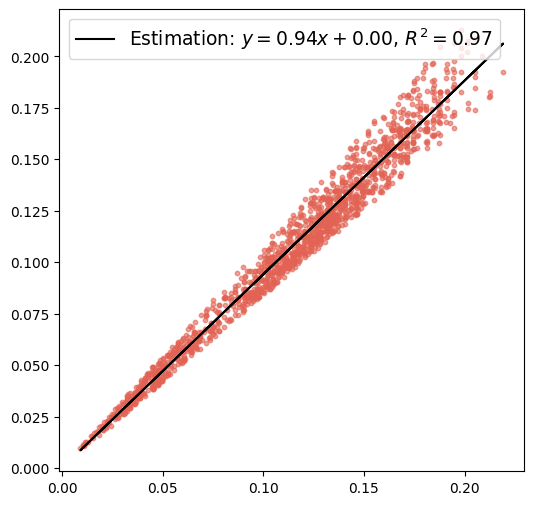

Scatter plot saved to /cpfs04/user/hanyujin/causal-dm/example/test.pdf


In [37]:
def plot_scatter(data, ratios, sum_points,output_pdf_path, data_name  = 'train'):
    with PdfPages(output_pdf_path) as pdf:
        plt.figure(figsize=(6, 6))
        if data_name == 'train':
            color = '#5762b8'
        else:
            color = '#E26354' 
        all_points = []


        for points in data.values():
            all_points.extend(points) 

        x_all = np.array([p[1][0] for p in all_points]) 
        y_all = np.array([p[1][1] for p in all_points]) 
        
        ratio_all = np.abs(y_all / x_all)

        # ratio_low, ratio_high = np.percentile(ratio_all, [2.5, 97.5])
        # ratio_low, ratio_high = np.percentile(ratio_all, [10, 90])
        # ratio_low, ratio_high = np.percentile(ratio_all, [15, 85])
        ratio_low, ratio_high = np.percentile(ratio_all, [25, 75])

        mask = (ratio_low <= ratio_all) & (ratio_all <= ratio_high)
        x_filtered = x_all[mask].reshape(-1, 1)
        y_filtered = y_all[mask]
        ratios = np.array(ratios)[mask] 
        plt.scatter(x_filtered ,y_filtered , c=color, alpha=0.6, s=10)

        lin_reg = LinearRegression()
        lin_reg.fit(x_filtered, y_filtered)
        y_pred = lin_reg.predict(x_filtered)
        r2 = r2_score(y_filtered, y_pred)
        slope = lin_reg.coef_[0]
        intercept = lin_reg.intercept_

        mask_hq = (ratio_all >= 0.95) & (ratio_all <= 1.05)
        count = np.sum(mask_hq)

        print("All Points:", len(all_points),len(all_points)/sum_points)
        print("High Quality 0.99-1.01:", sum((ratio_all >= 0.99) & (ratio_all <= 1.01)),sum((ratio_all >= 0.99) & (ratio_all <= 1.01))/sum_points)
        print("High Quality 0.95-1.05:", count,count/sum_points)
        print("High Quality 0.9-1.1:", sum((ratio_all >= 0.9) & (ratio_all <= 1.1)),sum((ratio_all >= 0.9) & (ratio_all <= 1.1))/sum_points)
        print("Filtered Ratios:", len(ratios))
        print(f"Max Ratio: {np.max(ratios)}")
        print(f"Min Ratio: {np.min(ratios)}")
        print(f"Bias Error: {np.sqrt((slope-1)**2)+np.sqrt(intercept**2)}")
        print(f"GAP Bias Error: {np.sqrt((slope-1)**2)+np.sqrt(intercept**2)-np.sqrt((slope-1)**2+intercept**2)}")
        print(f"Variance Error: {np.sqrt(np.mean((y_filtered - y_pred-np.mean(y_filtered - y_pred))**2)) }")
        print(f"Sum Error: {np.sqrt(np.mean((y_filtered - y_pred-np.mean(y_filtered - y_pred))**2))+np.sqrt((slope-1)**2)+np.sqrt(intercept**2)}")
        print(f"Mean Sqrt Variance Error: {(np.sqrt(np.mean(((y_filtered - y_pred) ** 2))))}")
        

        plt.plot(x_filtered, y_pred, color='black', 
                 label=f'Estimation: $y={slope:.2f}x+{intercept:.2f}$, $R^2={r2:.2f}$')

        plt.legend(fontsize=13.5)
        # plt.xlim(0,0.25)
        # plt.ylim(0,0.25)
        pdf.savefig()  
        plt.show()
        plt.close()

    print(f"Scatter plot saved to {output_pdf_path}")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.backends.backend_pdf import PdfPages

output_pdf_path = os.path.join("/cpfs04/user/hanyujin/causal-dm/example", "test.pdf")
plot_scatter(data, ratios, sum_points,output_pdf_path, data_name=data_name)


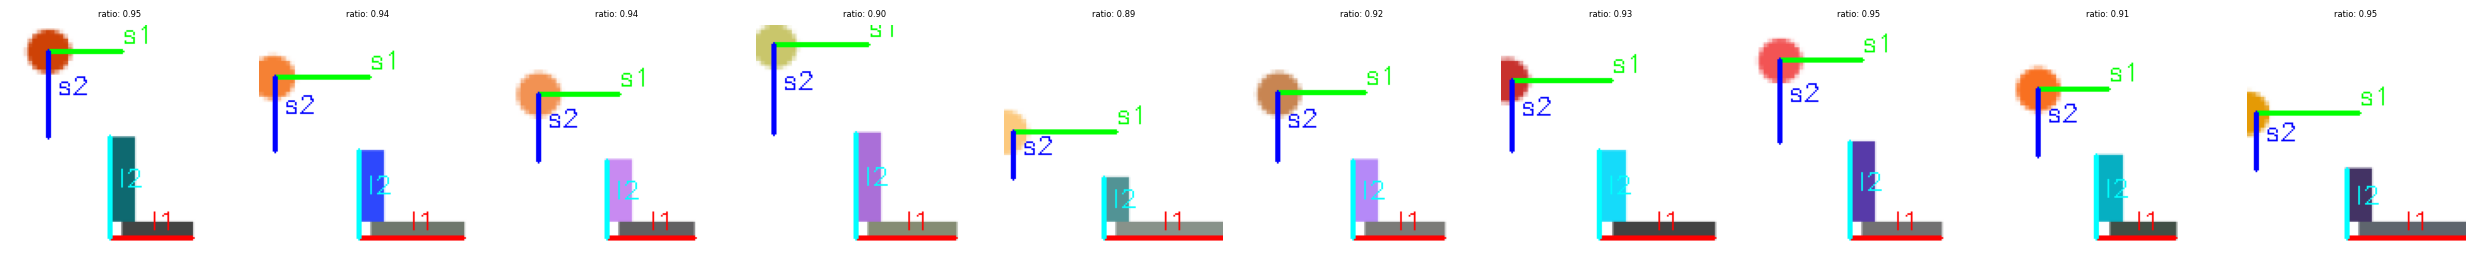

In [29]:
import random
def visualize_results(data, num_images=10):
    # 收集所有有效数据（包含图像和对应ratio）
    valid_entries = []
    for category in data:
        for entry in data[category]:
            if len(entry) >= 3:  # 确保数据结构正确
                img, (result_1, result_2), _ = entry[:3] 
                ratio = result_2 / result_1 if result_1 != 0 else 0
                valid_entries.append((img, ratio))

    if not valid_entries:
        print("没有有效数据")
        return

    # 计算分位区间
    ratios = np.array([x[1] for x in valid_entries])
    lower = np.percentile(ratios, 25)
    upper = np.percentile(ratios, 75)

    # 筛选并保留完整信息
    filtered_entries = [x for x in valid_entries if lower <= x[1] <= upper]
    
    if len(filtered_entries) < num_images:
        print(f"有效图像不足: {len(filtered_entries)}/{num_images}")
        return
    
    # 随机选择时保留对应ratio
    selected_entries = random.sample(filtered_entries, num_images)
    
    # 可视化
    fig, axes = plt.subplots(1, num_images, figsize=(25, 2.5))
    for idx, (img, ratio) in enumerate(selected_entries):
        try:
            img_uint8 = img.astype(np.uint8)
            img_rgb = cv2.cvtColor(img_uint8, cv2.COLOR_BGR2RGB)
        except Exception as e:
            print(f"图像处理错误: {str(e)}")
            img_rgb = img[:, :, ::-1]  # 应急BGR转RGB
        
        axes[idx].imshow(img_rgb)
        axes[idx].set_title(f"ratio: {ratio:.2f}", fontsize=6)
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_results(data)


In [4]:
import torch
vq_ckpt = "/cpfs04/user/hanyujin/rule-gen/experiments/tokenizer/exp003-kl-16/checkpoints/kl.pt"
checkpoint = torch.load(vq_ckpt, map_location="cpu", weights_only=False)

In [10]:
if "ema" in checkpoint:
    print(1)

1


In [7]:
checkpoint['model']

OrderedDict([('encoder.mask_token',
              tensor([[[ 2.1410e-02, -1.9606e-03,  1.8557e-02, -3.0591e-02,  8.1514e-03,
                        -5.2968e-04,  3.8362e-02,  3.5662e-02, -1.5955e-02,  3.8112e-03,
                        -1.1079e-02,  3.4201e-02, -6.2359e-03, -1.8038e-02,  1.7736e-03,
                         7.9768e-03, -1.6555e-03, -3.2295e-03, -1.0013e-02,  1.2365e-02,
                         9.5853e-03, -1.1376e-02,  3.1132e-02,  3.6010e-02, -2.3247e-02,
                        -4.1165e-02, -5.1620e-03, -1.2620e-02, -2.0318e-02,  3.2195e-02,
                        -2.4904e-04,  5.0201e-04,  2.4462e-02, -3.3884e-02, -2.0820e-02,
                        -7.0919e-03,  1.1973e-02,  1.1784e-03, -4.4627e-02,  2.6452e-02,
                        -2.1748e-02,  6.1988e-03, -3.7173e-03, -3.5818e-02,  9.8875e-03,
                        -2.0897e-02,  3.2192e-02, -5.4776e-03,  3.0980e-02,  1.3933e-02,
                        -1.8262e-02,  2.7294e-03, -2.4942e-02, -4.2015e-02

# Cifar-Mnist

In [2]:
import os
import random
import numpy as np
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# 配置参数
configs = [
    {
        "cifar_classes": ["dog", "cat"],
        "mnist_digits": [0, 1],
        "output_dir": "/cpfs04/user/hanyujin/rule-gen/datasets/cifar-mnist/dog-cat-0-1/"
    },
    {
        "cifar_classes": ["automobile", "truck"],
        "mnist_digits": [2, 3],
        "output_dir": "/cpfs04/user/hanyujin/rule-gen/datasets/cifar-mnist/auto-truck-2-3/"
    },
    {
        "cifar_classes": ["deer", "horse"],
        "mnist_digits": [4, 5],
        "output_dir": "/cpfs04/user/hanyujin/rule-gen/datasets/cifar-mnist/deer-horse-4-5/"
    },
    {
        "cifar_classes": ["airplane", "bird"],
        "mnist_digits": [6, 7],
        "output_dir": "/cpfs04/user/hanyujin/rule-gen/datasets/cifar-mnist/airplane-bird-6-7/"
    },
    {
        "cifar_classes": ["frog", "ship"],
        "mnist_digits": [8, 9],
        "output_dir": "/cpfs04/user/hanyujin/rule-gen/datasets/cifar-mnist/frog-ship-8-9/"
    }
]

# CIFAR-10类别映射
cifar10_classes = {
    'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3,
    'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7,
    'ship': 8, 'truck': 9
}

# 图像预处理
transform_cifar = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor()
])

transform_mnist = transforms.Compose([
    transforms.Resize(32),
    transforms.Grayscale(num_output_channels=3),  # 转换为RGB
    transforms.ToTensor()
])

# 加载完整数据集
cifar10_train = datasets.CIFAR10(root='/cpfs04/user/hanyujin/rule-gen/datasets', train=True, download=True, transform=transform_cifar)
mnist_train = datasets.MNIST(root='/cpfs04/user/hanyujin/rule-gen/datasets', train=True, download=False, transform=transform_mnist)

def create_composite_image(cifar_images, mnist_images):
    """ 创建组合图像 """
    # 合并所有图像并随机排列
    all_images = list(cifar_images) + list(mnist_images)
    random.shuffle(all_images)
    
    # 创建2x2网格
    composite = Image.new('RGB', (64, 64))
    for i, img in enumerate(all_images):
        row = i // 2
        col = i % 2
        composite.paste(img, (col*32, row*32))
    return composite

def process_config(config):
    """ 处理单个配置项 """
    # 创建输出目录
    os.makedirs(config["output_dir"], exist_ok=True)
    
    # 准备CIFAR-10数据
    cifar_indices = {}
    for cls in config["cifar_classes"]:
        class_idx = cifar10_classes[cls]
        indices = np.where(np.array(cifar10_train.targets) == class_idx)[0]
        cifar_indices[cls] = indices
    
    # 准备MNIST数据
    mnist_indices = {}
    for digit in config["mnist_digits"]:
        indices = np.where(np.array(mnist_train.targets) == digit)[0]
        mnist_indices[digit] = indices
    
    # 生成2000张组合图像
    for i in range(6000):
        # 随机选择图像
        cifar_samples = [
            cifar10_train[random.choice(cifar_indices[cls])][0]
            for cls in config["cifar_classes"]
        ]
        mnist_samples = [
            mnist_train[random.choice(mnist_indices[digit])][0]
            for digit in config["mnist_digits"]
        ]
        
        # 转换为PIL图像
        cifar_images = [
            transforms.ToPILImage()(img) for img in cifar_samples
        ]
        mnist_images = [
            transforms.ToPILImage()(img) for img in mnist_samples
        ]
        
        # 创建组合图像
        composite = create_composite_image(cifar_images, mnist_images)
        
        # 保存图像
        composite.save(os.path.join(config["output_dir"], f"composite_{i:04d}.png"))

# 处理所有配置项
for cfg in configs:
    process_config(cfg)

print("所有数据集生成完成！")

Files already downloaded and verified
所有数据集生成完成！


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import os

# 设备配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 数据预处理（添加数据增强）
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# 加载数据集
train_dataset = torchvision.datasets.CIFAR10(
    root='/cpfs04/user/hanyujin/rule-gen/datasets',
    train=True,
    download=False,
    transform=transform_train
)

test_dataset = torchvision.datasets.CIFAR10(
    root='/cpfs04/user/hanyujin/rule-gen/datasets',
    train=False,
    download=False,
    transform=transform_test
)

# train_dataset = torchvision.datasets.MNIST(
#     root='/cpfs04/user/hanyujin/rule-gen/datasets',
#     train=True,
#     download=False,
#     transform=transform_train
# )

# test_dataset = torchvision.datasets.MNIST(
#     root='/cpfs04/user/hanyujin/rule-gen/datasets',
#     train=False,
#     download=False,
#     transform=transform_test
# )

# 创建数据加载器
batch_size = 256
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# 定义CNN模型
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            # 输入: 3x32x32
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 输出: 64x16x16
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 输出: 128x8x8
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 输出: 256x4x4
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = CNN().to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5, factor=0.5, verbose=True)

# 创建保存目录
save_dir = "/cpfs04/user/hanyujin/rule-gen/model_cpkt"
os.makedirs(save_dir, exist_ok=True)
best_acc = 0.0

# 评估函数
def evaluate(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# 训练循环
for epoch in range(500):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # 前向传播
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    # 每10个epoch评估
    if (epoch + 1) % 10 == 0 or epoch == 0:
        train_acc = evaluate(train_loader)
        test_acc = evaluate(test_loader)
        scheduler.step(test_acc)  # 学习率调度
        
        # 保存最佳模型
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save({
                'epoch': epoch+1,
                'state_dict': model.state_dict(),
                'best_acc': best_acc,
                'optimizer' : optimizer.state_dict(),
            }, os.path.join(save_dir, "cifar_class_cnn_best.pth"))
        
        print(f"Epoch [{epoch+1}/100], "
              f"Loss: {running_loss/len(train_loader):.4f}, "
              f"Train Acc: {train_acc:.2f}%, "
              f"Test Acc: {test_acc:.2f}%")

print(f"Best Test Accuracy: {best_acc:.2f}%")

# Best Test Accuracy: 90.33%

Using device: cuda


AttributeError: module 'torchvision.datasets' has no attribute 'CMNIST'

## test

In [5]:
import torch.nn as nn
from PIL import Image
import torchvision.transforms as transforms

# -------------------- 1. 图像读取与分割 --------------------
def load_and_split_image(image_path):
    """加载64x64图像并分割为4张32x32子图"""
    image = Image.open(image_path)
    transform = transforms.ToTensor()
    img_tensor = transform(image)  # [3, 64, 64]

    # 分割为四个32x32块
    blocks = [
        img_tensor[:, :32, :32],    # 左上 (CIFAR)
        img_tensor[:, :32, 32:],    # 右上 (CIFAR)
        img_tensor[:, 32:, :32],    # 左下 (MNIST)
        img_tensor[:, 32:, 32:]     # 右下 (MNIST)
    ]
    return blocks

# -------------------- 2. 模型定义与加载 --------------------
class CIFAR_CNN(nn.Module):
    def __init__(self):
        super(CIFAR_CNN, self).__init__()
        self.features = nn.Sequential(
            # 输入: 3x32x32
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 输出: 64x16x16
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 输出: 128x8x8
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 输出: 256x4x4
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        self.features = nn.Sequential(
            # 输入: 1x28x28
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 输入通道改为1
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 输出: 32x14x14
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 输出: 64x7x7
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)  # 全局平均池化输出: 128x1x1
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

        

In [6]:
import torch
import torch.nn as nn
from PIL import Image
import torchvision.transforms as transforms
import os
from tqdm import tqdm

# -------------------- 1. 读取数据 --------------------
def load_and_split_image(image_path):
    """加载图片并切割成4块"""
    image = Image.open(image_path)
    transform = transforms.ToTensor()
    img_tensor = transform(image)
    return [
        img_tensor[:, :32, :32],    # 左上
        img_tensor[:, :32, 32:],    # 右上
        img_tensor[:, 32:, :32],    # 左下
        img_tensor[:, 32:, 32:]     # 右下
    ]

# -------------------- 2. 预测 --------------------
def predict_with_confidence_diff(blocks, cifar_model, mnist_model, device):
    """使用两个模型分别预测CIFAR和MNIST"""
    cifar_transform = transforms.Compose([
        transforms.Resize(32),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])
    
    mnist_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.Grayscale(num_output_channels=1),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    diff_records = []
    for idx, block in enumerate(blocks):
        cifar_input = cifar_transform(block).unsqueeze(0).to(device)
        mnist_input = mnist_transform(block).unsqueeze(0).to(device)

        with torch.no_grad():
            cifar_conf, cifar_pred = torch.nn.functional.softmax(cifar_model(cifar_input), dim=1).max(dim=1)
            mnist_conf, mnist_pred = torch.nn.functional.softmax(mnist_model(mnist_input), dim=1).max(dim=1)

        diff = mnist_conf.item() - cifar_conf.item()
        diff_records.append((idx, diff, mnist_conf.item(), cifar_conf.item()))

    sorted_diffs = sorted(diff_records, key=lambda x: -x[1])

    mnist_indices = {x[0] for x in sorted_diffs[:2]}  # 最高的两个 -> MNIST
    cifar_indices = {x[0] for x in sorted_diffs[2:]}  # 剩下的两个 -> CIFAR

    results = []
    for idx in range(4):
        if idx in mnist_indices:
            input_tensor = mnist_transform(blocks[idx]).unsqueeze(0).to(device)
            with torch.no_grad():
                pred = mnist_model(input_tensor).argmax().item()
            results.append(str(pred))  # MNIST 直接存数字字符串
        else:
            input_tensor = cifar_transform(blocks[idx]).unsqueeze(0).to(device)
            with torch.no_grad():
                pred = cifar_model(input_tensor).argmax().item()
            results.append(class_names_cifar[pred])  # CIFAR 存文字标签

    return set(results)  # 返回无序集合

# -------------------- 3. 计算准确率 --------------------
def evaluate_model(dataset_path, cifar_model, mnist_model, device):
    """计算数据集的准确率，并在进度条中实时显示"""
    total_images = 0
    correct_predictions = 0

    image_files = [f for f in os.listdir(dataset_path) if f.endswith(".png")]
    true_label_set = set(os.path.basename(os.path.normpath(dataset_path)).split('-'))

    # 初始化 tqdm 进度条
    progress_bar = tqdm(image_files, desc="Processing images", position=0, dynamic_ncols=True)

    for img_file in progress_bar:
        img_path = os.path.join(dataset_path, img_file)
        blocks = load_and_split_image(img_path)

        predicted_set = predict_with_confidence_diff(blocks, cifar_model, mnist_model, device)

        if predicted_set == true_label_set:
            correct_predictions += 1
        total_images += 1

        # 计算当前 Accuracy
        accuracy = correct_predictions / total_images if total_images > 0 else 0
        progress_bar.set_postfix({"Accuracy": f"{accuracy:.2%}"})  # 在进度条后面动态更新 Accuracy

    print(f"\nFinal Accuracy: {accuracy:.2%}")
    return accuracy


# -------------------- 4. 运行 --------------------
# if __name__ == "__main__":
#     dataset_path = "/cpfs04/user/hanyujin/rule-gen/datasets/cifar-mnist/frog-ship-8-9"
    
#     # 需要定义 CIFAR 和 MNIST 的类别名称
#     class_names_cifar = ['airplane', 'automobile', 'bird', 'cat', 'deer',
#                          'dog', 'frog', 'horse', 'ship', 'truck']
    
#     # 选择设备：CUDA 或 CPU
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     print(f"Using device: {device}")

#     # 加载 CIFAR 模型
#     cifar_model = CIFAR_CNN().to(device)
#     checkpoint = torch.load('/cpfs04/user/hanyujin/rule-gen/model_cpkt/cifar_class_cnn_best.pth', map_location=device)
#     cifar_model.load_state_dict(checkpoint['state_dict'])
#     cifar_model.eval()  # 设为评估模式

#     # 加载 MNIST 模型
#     mnist_model = MNIST_CNN().to(device)
#     checkpoint = torch.load('/cpfs04/user/hanyujin/rule-gen/model_cpkt/mnist_cnn_best.pth', map_location=device)
#     mnist_model.load_state_dict(checkpoint['state_dict'])
#     mnist_model.eval()  # 设为评估模式

#     # 计算准确率
#     evaluate_model(dataset_path, cifar_model, mnist_model, device)

# dataset_path = "/cpfs04/user/hanyujin/rule-gen/datasets/cifar-mnist/airplane-bird-6-7/" Accuracy: 93.38%
# dataset_path = "/cpfs04/user/hanyujin/rule-gen/datasets/cifar-mnist/automobile-truck-2-3" Accuracy: 92.50%
# /cpfs04/user/hanyujin/rule-gen/datasets/cifar-mnist/deer-horse-4-5 Accuracy: 90.72%
# /cpfs04/user/hanyujin/rule-gen/datasets/cifar-mnist/dog-cat-0-1 Accuracy=97.33%
# /cpfs04/user/hanyujin/rule-gen/datasets/cifar-mnist/frog-ship-8-9 Accuracy=88.82%

# 23.01%

In [1]:
import numpy as np
data = ["Training", "Generation"]
a = [93.38,92.50,90.72,97.33,88.82]
tr_acc = np.mean(a)
gen_acc = 23.01

92.55

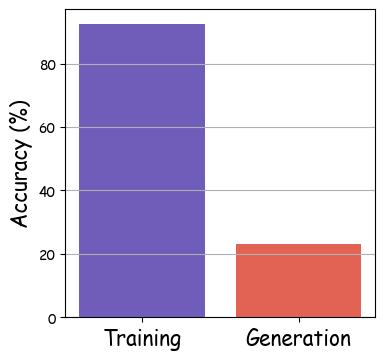

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

comic_sans_path = "/usr/share/fonts/truetype/msttcorefonts/comic.ttf"  # Linux 常见路径
if os.path.exists(comic_sans_path):
    fm.fontManager.addfont(comic_sans_path)
    plt.rcParams['font.family'] = 'Comic Sans MS'
else:
    print("Comic Sans MS font not found. Using default font.")
data = ["Training", "Generation"]
a = [93.38, 92.50, 90.72, 97.33, 88.82]
tr_acc = np.mean(a)
gen_acc = 23.01

# Values for the bar chart
values = [tr_acc, gen_acc]
plt.figure(figsize=(4, 4))
# Colors for the bars
colors = ["#6f5db9", "#E26354"]
plt.xticks(fontsize=15)
# plt.yticks(fontsize=12)
# Plotting the bar chart
plt.bar(data, values, color=colors)
plt.ylabel("Accuracy (%)", fontsize=15)
plt.grid(True, axis='y')
# plt.title("Training vs. Generation Accuracy")
plt.show()


In [9]:
import os
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm


def predict_with_confidence_diff(blocks, cifar_model, mnist_model, device):
    """使用两个模型分别预测CIFAR和MNIST"""
    cifar_transform = transforms.Compose([
        transforms.Resize(32),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])
    
    mnist_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.Grayscale(num_output_channels=1),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    diff_records = []
    for idx, block in enumerate(blocks):
        cifar_input = cifar_transform(block).unsqueeze(0).to(device)
        mnist_input = mnist_transform(block).unsqueeze(0).to(device)

        with torch.no_grad():
            cifar_conf, cifar_pred = torch.nn.functional.softmax(cifar_model(cifar_input), dim=1).max(dim=1)
            mnist_conf, mnist_pred = torch.nn.functional.softmax(mnist_model(mnist_input), dim=1).max(dim=1)

        diff = mnist_conf.item() - cifar_conf.item()
        diff_records.append((idx, diff, mnist_conf.item(), cifar_conf.item()))

    sorted_diffs = sorted(diff_records, key=lambda x: -x[1])

    mnist_indices = {x[0] for x in sorted_diffs[:2]}  # 最高的两个 -> MNIST
    cifar_indices = {x[0] for x in sorted_diffs[2:]}  # 剩下的两个 -> CIFAR

    results = []
    for idx in range(4):
        if idx in mnist_indices:
            input_tensor = mnist_transform(blocks[idx]).unsqueeze(0).to(device)
            with torch.no_grad():
                pred = mnist_model(input_tensor).argmax().item()
            results.append(str(pred))  # MNIST 直接存数字字符串
        else:
            input_tensor = cifar_transform(blocks[idx]).unsqueeze(0).to(device)
            with torch.no_grad():
                pred = cifar_model(input_tensor).argmax().item()
            results.append(class_names_cifar[pred])  # CIFAR 存文字标签

    return set(results)  # 返回无序集合



# def evaluate_and_analyze(dataset_path, cifar_model, mnist_model, device):
#     """评估生成图像，并统计标签分布，计算匹配百分比及错误情况"""
#     total_images = 0
#     correct_predictions = 0
#     label_counts = defaultdict(int)  # 统计预测标签的数量

#     # 真实标签集合（忽略顺序）
#     true_label_pools = [
#         frozenset(["airplane", "bird", "6", "7"]),
#         frozenset(["automobile", "truck", "2", "3"]),
#         frozenset(["deer", "horse", "4", "5"]),
#         frozenset(["dog", "cat", "0", "1"]),
#         frozenset(["frog", "ship", "8", "9"])
#     ]

#     # 错误分类统计
#     mnist_errors = 0
#     cifar_errors = 0
#     both_errors = 0
#     wrong_label_counts = defaultdict(int)
    
#     # 存储错误的图片文件名
#     mnist_error_files = []
#     cifar_error_files = []
#     both_error_files = []

#     image_files = [f for f in os.listdir(dataset_path) if f.endswith(".png")]

#     # 初始化进度条
#     progress_bar = tqdm(image_files, desc="Processing images", position=0, dynamic_ncols=True)

#     for img_file in progress_bar:
#         img_path = os.path.join(dataset_path, img_file)
#         blocks = load_and_split_image(img_path)

#         # 预测的标签集合（无序）
#         predicted_set = predict_with_confidence_diff(blocks, cifar_model, mnist_model, device)
#         predicted_set = frozenset(predicted_set)

#         # 统计标签数量
#         label_counts[predicted_set] += 1
#         total_images += 1

#         # 判断预测的标签是否正确
#         if predicted_set in true_label_pools:
#             correct_predictions += 1
#         else:
#             # 统计错误情况
#             wrong_label_counts[predicted_set] += 1

#             # 计算 MNIST 和 CIFAR 的错误情况
#             mnist_correct = any(str(i) in predicted_set for i in range(10))
#             cifar_correct = any(label in predicted_set for label in ["airplane", "bird", "automobile", "truck",
#                                                                      "deer", "horse", "dog", "cat", "frog", "ship"])
#             if mnist_correct and not cifar_correct:
#                 cifar_errors += 1
#                 cifar_error_files.append(img_file)
#             elif not mnist_correct and cifar_correct:
#                 mnist_errors += 1
#                 mnist_error_files.append(img_file)
#             else:
#                 both_errors += 1
#                 both_error_files.append(img_file)

#         # 计算当前匹配百分比
#         match_percentage = correct_predictions / total_images if total_images > 0 else 0
#         progress_bar.set_postfix({
#             "Match %": f"{match_percentage:.2%}",
#             "Errors (MNIST, CIFAR, Both)": f"({mnist_errors}, {cifar_errors}, {both_errors})"
#         })

#     print(f"\nFinal Match Percentage: {match_percentage:.2%}")
#     print(f"MNIST Errors: {mnist_errors}, CIFAR Errors: {cifar_errors}, Both Errors: {both_errors}")

#     # 画分布图
#     # plot_label_distribution(label_counts, true_label_pools, wrong_label_counts)
#     plot_label_distribution(label_counts, true_label_pools, wrong_label_counts, label_to_images)


#     # 保存错误的文件名
#     save_wrong_labels( dataset_path,mnist_error_files, cifar_error_files, both_error_files)


# def plot_label_distribution(label_counts, true_label_pools, wrong_label_counts):
#     """绘制预测标签分布直方图，并打印预测标签"""
#     labels = ['-'.join(sorted(label)) for label in label_counts.keys()]
#     counts = list(label_counts.values())

#     # 颜色区分：在真实标签集合内的红色，否则蓝色
#     colors = ['red' if frozenset(label.split('-')) in true_label_pools else 'blue' for label in labels]

#     plt.figure(figsize=(12, 6))
#     plt.bar(labels, counts, color=colors)
#     plt.xlabel("Predicted Labels (unordered)")
#     plt.ylabel("Count")
#     plt.title("Distribution of Predicted Labels")
#     plt.xticks(rotation=45, ha="right")
#     plt.tight_layout()
#     plt.show()

#     # 打印完整的预测标签分布
#     print("\nPredicted Labels Distribution:")
#     for label, count in sorted(label_counts.items(), key=lambda x: -x[1]):
#         print(f"{'-'.join(sorted(label))}: {count}")

#     # 额外统计错误预测标签的数量
#     if wrong_label_counts:
#         print("\nTop Wrong Predictions:")
#         for label, count in sorted(wrong_label_counts.items(), key=lambda x: -x[1])[:10]:
#             print(f"{'-'.join(sorted(label))}: {count}")


def evaluate_and_analyze(dataset_path, cifar_model, mnist_model, device):
    """评估生成图像，并统计标签分布，计算匹配百分比及错误情况"""
    total_images = 0
    correct_predictions = 0
    label_counts = defaultdict(int)  # 统计预测标签的数量
    label_to_images = defaultdict(list)  # 记录每个类别的图片路径

    # 真实标签集合（忽略顺序）
    true_label_pools = [
        frozenset(["airplane", "bird", "6", "7"]),
        frozenset(["automobile", "truck", "2", "3"]),
        frozenset(["deer", "horse", "4", "5"]),
        frozenset(["dog", "cat", "0", "1"]),
        frozenset(["frog", "ship", "8", "9"])
    ]

    # 错误分类统计
    mnist_errors = 0
    cifar_errors = 0
    both_errors = 0
    wrong_label_counts = defaultdict(int)
    
    # 存储错误的图片文件名
    mnist_error_files = []
    cifar_error_files = []
    both_error_files = []

    image_files = [f for f in os.listdir(dataset_path) if f.endswith(".png")]

    # 初始化进度条
    progress_bar = tqdm(image_files, desc="Processing images", position=0, dynamic_ncols=True)

    for img_file in progress_bar:
        img_path = os.path.join(dataset_path, img_file)
        blocks = load_and_split_image(img_path)

        # 预测的标签集合（无序）
        predicted_set = predict_with_confidence_diff(blocks, cifar_model, mnist_model, device)
        predicted_set = frozenset(predicted_set)

        # 统计标签数量
        label_counts[predicted_set] += 1
        label_to_images[predicted_set].append(img_path)  # 记录图片路径
        total_images += 1

        # 判断预测的标签是否正确
        if predicted_set in true_label_pools:
            correct_predictions += 1
        else:
            # 统计错误情况
            wrong_label_counts[predicted_set] += 1

            # 计算 MNIST 和 CIFAR 的错误情况
            mnist_correct = any(str(i) in predicted_set for i in range(10))
            cifar_correct = any(label in predicted_set for label in ["airplane", "bird", "automobile", "truck",
                                                                     "deer", "horse", "dog", "cat", "frog", "ship"])
            if mnist_correct and not cifar_correct:
                cifar_errors += 1
                cifar_error_files.append(img_file)
            elif not mnist_correct and cifar_correct:
                mnist_errors += 1
                mnist_error_files.append(img_file)
            else:
                both_errors += 1
                both_error_files.append(img_file)

        # 计算当前匹配百分比
        match_percentage = correct_predictions / total_images if total_images > 0 else 0
        progress_bar.set_postfix({
            "Match %": f"{match_percentage:.2%}",
            "Errors (MNIST, CIFAR, Both)": f"({mnist_errors}, {cifar_errors}, {both_errors})"
        })

    print(f"\nFinal Match Percentage: {match_percentage:.2%}")
    print(f"MNIST Errors: {mnist_errors}, CIFAR Errors: {cifar_errors}, Both Errors: {both_errors}")

    # 画分布图并保存图片
    plot_label_distribution(label_counts, true_label_pools, wrong_label_counts, label_to_images, dataset_path)

    # 保存错误的文件名
    save_wrong_labels(dataset_path, mnist_error_files, cifar_error_files, both_error_files)


def plot_label_distribution(label_counts, true_label_pools, wrong_label_counts, label_to_images, dataset_path):
    """绘制预测标签分布直方图，并保存每个类别的图片"""
    labels = ['-'.join(sorted(label)) for label in label_counts.keys()]
    counts = list(label_counts.values())

    # 颜色区分：在真实标签集合内的红色，否则蓝色
    colors = ['red' if frozenset(label.split('-')) in true_label_pools else 'blue' for label in labels]

    plt.figure(figsize=(12, 6))
    plt.bar(labels, counts, color=colors)
    plt.xlabel("Predicted Labels (unordered)")
    plt.ylabel("Count")
    plt.title("Distribution of Predicted Labels")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    # 保存直方图
    hist_path = os.path.join(dataset_path, "predicted_labels_distribution.png")
    plt.savefig(hist_path)
    plt.close()
    print(f"Saved histogram at {hist_path}")

    # 创建用于存放采样图片的目录
    sample_img_dir = os.path.join(dataset_path, "sampled_images")
    os.makedirs(sample_img_dir, exist_ok=True)

    # 选取每个类别的 5 张图片并保存
    print("\nSaving sample images for each predicted label:")

    for label, img_paths in label_to_images.items():
        img_samples = img_paths[:5]  # 选取最多 5 张

        for img_idx, img_path in enumerate(img_samples):
            img = plt.imread(img_path)  # 读取图片
            save_path = os.path.join(sample_img_dir, f"{'-'.join(sorted(label))}_{img_idx}.png")
            plt.imsave(save_path, img)
    
    print(f"Saved sampled images at {sample_img_dir}")


def save_wrong_labels(dataset_path,mnist_error_files, cifar_error_files, both_error_files):
    """保存错误标签的图片文件名到TXT文件"""
    os.makedirs(dataset_path+"/wrong_labels", exist_ok=True)

    with open(dataset_path+"/wrong_labels/mnist_errors.txt", "w") as f:
        for filename in mnist_error_files:
            f.write(f"{filename}\n")

    with open(dataset_path+"/wrong_labels/cifar_errors.txt", "w") as f:
        for filename in cifar_error_files:
            f.write(f"{filename}\n")

    with open(dataset_path+"/wrong_labels/both_errors.txt", "w") as f:
        for filename in both_error_files:
            f.write(f"{filename}\n")

    print("\nSaved wrong label filenames to 'wrong_labels/' directory.")


if __name__ == "__main__":
    dataset_path = "/cpfs04/user/hanyujin/rule-gen/experiments_sep/samples/cifar-mnist-SiT-B-1-linear-vae0046800.pt-size-64cfg-4.0-seed-0"
    class_names_cifar = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                         'dog', 'frog', 'horse', 'ship', 'truck']
    # 选择设备：CUDA 或 CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 加载 CIFAR 模型
    cifar_model = CIFAR_CNN().to(device)
    checkpoint = torch.load('/cpfs04/user/hanyujin/rule-gen/model_cpkt/cifar_class_cnn_best.pth', map_location=device)
    cifar_model.load_state_dict(checkpoint['state_dict'])
    cifar_model.eval()  # 设为评估模式

    # 加载 MNIST 模型
    mnist_model = MNIST_CNN().to(device)
    checkpoint = torch.load('/cpfs04/user/hanyujin/rule-gen/model_cpkt/mnist_cnn_best.pth', map_location=device)
    mnist_model.load_state_dict(checkpoint['state_dict'])
    mnist_model.eval()  # 设为评估模式

    # 计算准确率
    evaluate_and_analyze(dataset_path, cifar_model, mnist_model, device)


# AE-JEPA
# Final Match Percentage: 44.69%
# MNIST Errors: 0, CIFAR Errors: 0, Both Errors: 1699

# AE
# Final Match Percentage: 23.01%
# MNIST Errors: 0, CIFAR Errors: 0, Both Errors: 2365




Using device: cuda


Processing images:  14%|█▍        | 445/3073 [00:42<04:09, 10.52it/s, Match %=20.22%, Errors (MNIST, CIFAR, Both)=(0, 0, 355)]


RuntimeError: The size of tensor a (4) must match the size of tensor b (3) at non-singleton dimension 0

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm

def evaluate_and_analyze(dataset_path, cifar_model, mnist_model, device):
    """评估生成图像，并统计标签分布，计算匹配百分比及错误情况"""
    total_images = 0
    correct_predictions = 0
    label_counts = defaultdict(int)  # 统计预测标签的数量
    wrong_label_files = defaultdict(list)  # 按错误类别存储文件名

    true_label_pools = [
        frozenset(["airplane", "bird", "6", "7"]),
        frozenset(["automobile", "truck", "2", "3"]),
        frozenset(["deer", "horse", "4", "5"]),
        frozenset(["dog", "cat", "0", "1"]),
        frozenset(["frog", "ship", "8", "9"])
    ]

    image_files = [f for f in os.listdir(dataset_path) if f.endswith(".png")]
    progress_bar = tqdm(image_files, desc="Processing images", position=0, dynamic_ncols=True)

    for img_file in progress_bar:
        img_path = os.path.join(dataset_path, img_file)
        blocks = load_and_split_image(img_path)
        predicted_set = predict_with_confidence_diff(blocks, cifar_model, mnist_model, device)
        predicted_set = frozenset(predicted_set)

        label_counts[predicted_set] += 1
        total_images += 1

        if predicted_set not in true_label_pools:
            wrong_label_files[predicted_set].append(img_file)

        match_percentage = correct_predictions / total_images if total_images > 0 else 0
        progress_bar.set_postfix({"Match %": f"{match_percentage:.2%}"})

    print(f"\nFinal Match Percentage: {match_percentage:.2%}")

    # **修正：将 wrong_label_files 转换成计数信息用于绘图**
    wrong_label_counts = {k: len(v) for k, v in wrong_label_files.items()}
    plot_label_distribution(label_counts, true_label_pools, wrong_label_counts)

    # **保存错误的图片文件名**
    save_wrong_labels(dataset_path, wrong_label_files)


def plot_label_distribution(label_counts, true_label_pools, wrong_label_counts):
    """绘制预测标签分布直方图，并打印预测标签"""
    labels = ['-'.join(sorted(label)) for label in label_counts.keys()]
    counts = list(label_counts.values())

    # 颜色区分：在真实标签集合内的红色，否则蓝色
    colors = ['red' if frozenset(label.split('-')) in true_label_pools else 'blue' for label in labels]

    plt.figure(figsize=(12, 6))
    plt.bar(labels, counts, color=colors)
    plt.xlabel("Predicted Labels (unordered)")
    plt.ylabel("Count")
    plt.title("Distribution of Predicted Labels")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    print("\nPredicted Labels Distribution:")
    for label, count in sorted(label_counts.items(), key=lambda x: -x[1]):
        print(f"{'-'.join(sorted(label))}: {count}")

    # **修正：wrong_label_counts 现在是 {frozenset: int}，不再是 list**
    if wrong_label_counts:
        print("\nTop Wrong Predictions:")
        for label, count in sorted(wrong_label_counts.items(), key=lambda x: -x[1])[:10]:
            print(f"{'-'.join(sorted(label))}: {count}")


def save_wrong_labels(dataset_path, wrong_label_files):
    """按具体的错误预测类别存储错误的图片文件名到 TXT 文件"""
    os.makedirs(os.path.join(dataset_path, "wrong_labels"), exist_ok=True)

    for label, filenames in wrong_label_files.items():
        file_path = os.path.join(dataset_path, "wrong_labels", f"{'-'.join(sorted(label))}.txt")
        with open(file_path, "w") as f:
            for filename in filenames:
                f.write(f"{filename}\n")

    print("\nSaved wrong label filenames to 'wrong_labels/' directory.")


if __name__ == "__main__":
    # dataset_path = "/cpfs04/user/hanyujin/rule-gen/experiments/samples/cifar-mnist-SiT-B-1-linear-vae0046800.pt-size-64cfg-4.0-seed-0"
    dataset_path = "/cpfs04/user/hanyujin/rule-gen/experiments/samples/cifar-mnist-SiT-B-1-linear-vae0117000.pt-size-64cfg-4.0-seed-0"
    
    # 选择设备：CUDA 或 CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 加载 CIFAR 模型
    cifar_model = CIFAR_CNN().to(device)
    checkpoint = torch.load('/cpfs04/user/hanyujin/rule-gen/model_cpkt/cifar_class_cnn_best.pth', map_location=device)
    cifar_model.load_state_dict(checkpoint['state_dict'])
    cifar_model.eval()  # 设为评估模式

    # 加载 MNIST 模型
    mnist_model = MNIST_CNN().to(device)
    checkpoint = torch.load('/cpfs04/user/hanyujin/rule-gen/model_cpkt/mnist_cnn_best.pth', map_location=device)
    mnist_model.load_state_dict(checkpoint['state_dict'])
    mnist_model.eval()  # 设为评估模式

    # 计算准确率
    evaluate_and_analyze(dataset_path, cifar_model, mnist_model, device)


# Loss

## Sunshadow

In [18]:
import wandb

api = wandb.Api()
# run = api.run("yujinhan-the-university-of-hong-kong/autoregressive-diffusion/runs/v5bf89ac")
run = api.run("yujinhan-the-university-of-hong-kong/autoregressive-diffusion/runs/tzxa8yv6")
# history = run.scan_history(keys=["_step", "loss","single_loss"])
history = run.scan_history(keys=["_step", "loss"])

import pandas as pd
data = pd.DataFrame(history)

data.to_csv("/cpfs04/user/hanyujin/causal-dm/AR_diff/loss/shadow_ddpm_mlp.csv", index=False)


True


In [8]:
len(df_ar)

125001

Calculating variance: 100%|██████████| 125001/125001 [00:04<00:00, 28289.36it/s]


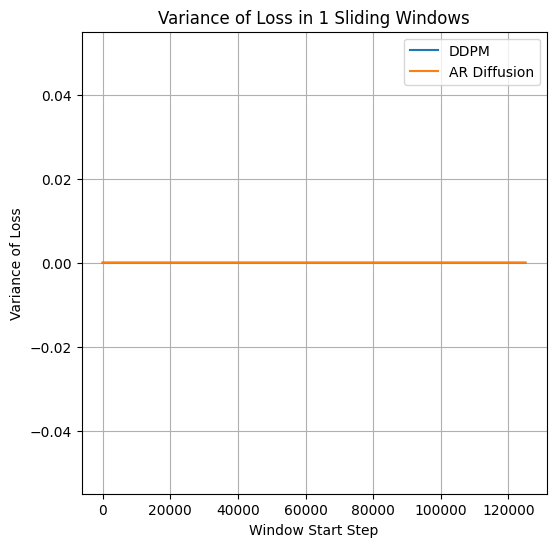

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
group_size = 250

file_path = "/cpfs04/user/hanyujin/causal-dm/AR_diff/loss/shadow_ar16.csv"
df = pd.read_csv(file_path)
df = df[['_step', 'loss']]
leng = len(df)
# df['group'] = (df.index // group_size)
# df = df.groupby('group').agg({'_step': 'first', 'loss': 'mean'}).reset_index(drop=True)


file_path = "/cpfs04/user/hanyujin/causal-dm/AR_diff/loss/shadow_ar16_unet.csv"
df_ar = pd.read_csv(file_path)
df_ar = df_ar[['_step', 'loss']]
df_ar = df_ar.iloc[:leng, :]
df_ar['_step'] = df_ar['_step']  - 1
# df_ar['group'] = (df_ar.index // group_size)
# df_ar = df_ar.groupby('group').agg({'_step': 'first', 'loss': 'mean'}).reset_index(drop=True)


# file_path = "/cpfs04/user/hanyujin/causal-dm/AR_diff/loss/shadow_ar16_parallel.csv"
# df_ar_par = pd.read_csv(file_path)
# df_ar_par  = df_ar_par[['_step', 'loss']]
# df_ar_par  = df_ar_par.iloc[:leng, :]
# df_ar_par['_step'] = df_ar_par['_step']  - 1
# df_ar_par['group'] = (df_ar_par.index // group_size)
# df_ar_par = df_ar_par.groupby('group').agg({'_step': 'first', 'loss': 'mean'}).reset_index(drop=True)


def calculate_loss_variance(df, k):
    variances = []
    for i in tqdm(range(0, len(df) - k + 1, k), desc="Calculating variance"):
        window_loss = df['loss'].iloc[i:i+k]
        variance = np.var(window_loss)
        variances.append(variance)
        # print(f"Start {i} with Variance {variance}")
    return variances, df['_step'].iloc[::k].values

import matplotlib.pyplot as plt

k = 1

variances, steps = calculate_loss_variance(df, k)
variances_ar, steps_ar = calculate_loss_variance(df_ar, k)
# variances_ar_par, steps_ar_par = calculate_loss_variance(df_ar, k)

plt.figure(figsize=(6, 6))
plt.plot(steps, variances, label=f'DDPM')
plt.plot(steps, variances_ar, label=f'AR Diffusion')
# plt.plot(steps_ar_par, variances_ar_par, label=f'Parallel AR')
plt.xlabel('Window Start Step')
plt.ylabel('Variance of Loss')
plt.title(f'Variance of Loss in {k} Sliding Windows')
plt.grid(True)
plt.legend()
plt.show()


In [9]:
len(steps)

1251

Calculating variance: 100%|██████████| 244/244 [00:00<00:00, 17670.59it/s]
/tmp/ipykernel_2288168/3249388732.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


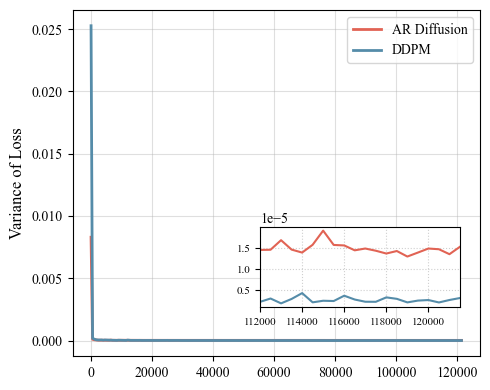

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import font_manager as fm
import os

# 设置 Times New Roman 字体
# times_new_roman_path = "/usr/share/fonts/truetype/msttcorefonts/times.ttf"
# if os.path.exists(times_new_roman_path):
#     fm.fontManager.addfont(times_new_roman_path)
#     plt.rcParams['font.family'] = 'Times New Roman'

# ---------------------- 数据加载部分保持不变 ----------------------
group_size = 250

file_path = "/cpfs04/user/hanyujin/causal-dm/AR_diff/loss/shadow_ddpm.csv"
df = pd.read_csv(file_path)
df = df[['_step', 'loss']]
leng = len(df)

file_path = "/cpfs04/user/hanyujin/causal-dm/AR_diff/loss/shadow_ar16.csv"
df_ar = pd.read_csv(file_path)
df_ar = df_ar[['_step', 'loss']]
df_ar = df_ar.iloc[:leng, :]
df_ar['_step'] = df_ar['_step'] - 1

file_path = "/cpfs04/user/hanyujin/causal-dm/AR_diff/loss/shadow_ar16_parallel.csv"
df_ar_par = pd.read_csv(file_path)
df_ar_par = df_ar_par[['_step', 'loss']]
df_ar_par = df_ar_par.iloc[:leng, :]
df_ar_par['_step'] = df_ar_par['_step'] - 1

def calculate_loss_variance(df, k):
    variances = []
    for i in tqdm(range(0, len(df) - k + 1, k), desc="Calculating variance"):
        window_loss = df['loss'].iloc[i:i+k]
        variance = np.var(window_loss)
        variances.append(variance)
    return variances, df['_step'].iloc[::k].values

k = 500
variances, steps = calculate_loss_variance(df, k)
variances_ar, steps_ar = calculate_loss_variance(df_ar, k)
variances_ar_par, steps_ar_par = calculate_loss_variance(df_ar_par, k)  # 注意这里应该使用 df_ar_par

# ---------------------- 绘图部分修改 ----------------------
# 创建复合图形布局
plt.figure(figsize=(5, 4))
# gs = fig.add_gridspec(  1, 1, height_ratios=[3, 1], hspace=0.15)

# 主图设置
# plt.add_subplot(gs[0])
plt.plot(steps_ar, variances_ar, label='AR Diffusion', color='#e16354', linewidth=2)
plt.plot(steps, variances, label='DDPM', color='#558ca9', linewidth=2)
# plt.plot(steps_ar, variances_ar, label='AR Diffusion', color='#e16354', linewidth=2)
# ax_main.plot(steps_ar_par, variances_ar_par, '--', 
#             label='AR Parallel', color='#fea443', linewidth=2)

plt.ylabel('Variance of Loss', fontsize=12)
plt.legend(fontsize=10, loc='upper right')
plt.grid(True, alpha=0.4)
plt.tick_params(axis='both', labelsize=10)

# 子图设置（最后500窗口的细节）
# ax_zoom = fig.add_subplot(gs[1])
zoom_window = 20  # 需要放大的窗口数

# 截取最后500个窗口的数据
def get_last_n_data(data, steps, n):
    return data[-n:], steps[-n:]

zoom_var, zoom_steps = get_last_n_data(variances, steps, zoom_window)
zoom_var_ar, zoom_steps_ar = get_last_n_data(variances_ar, steps_ar, zoom_window)
# zoom_var_par, zoom_steps_par = get_last_n_data(variances_ar_par, steps_ar_par, zoom_window)
left, bottom, width, height = [0.53, 0.22, 0.4, 0.2] 
ax_zoom = plt.axes([left, bottom, width, height]) 
# 绘制子图
ax_zoom.plot(zoom_steps_ar, zoom_var_ar, color='#e16354', linewidth=1.5)
ax_zoom.plot(zoom_steps, zoom_var, color='#558ca9', linewidth=1.5)
# ax_zoom.plot(zoom_steps_ar, zoom_var_ar, color='#e16354', linewidth=1.5)
# ax_zoom.plot(zoom_steps_par, zoom_var_par, '--', color='#fea443', linewidth=1.5)

# 子图标注设置
# ax_zoom.set_xlabel('Window Start Step', fontsize=12)
# ax_zoom.set_ylabel('Variance', fontsize=10)
ax_zoom.grid(True, linestyle=':', alpha=0.6)
ax_zoom.tick_params(axis='both', labelsize=8)

# 自动调整坐标范围
zoom_start = min(zoom_steps[0], zoom_steps_ar[0])
zoom_end = max(zoom_steps[-1], zoom_steps_ar[-1])
ax_zoom.set_xlim(zoom_start, zoom_end)

# 保存图片
output_path = "/cpfs04/user/hanyujin/causal-dm/ar_ddpm/task1_variance.pdf"
plt.tight_layout()
plt.savefig(output_path, format='pdf', bbox_inches='tight', dpi=300)
plt.show()

In [8]:
len(steps)

244

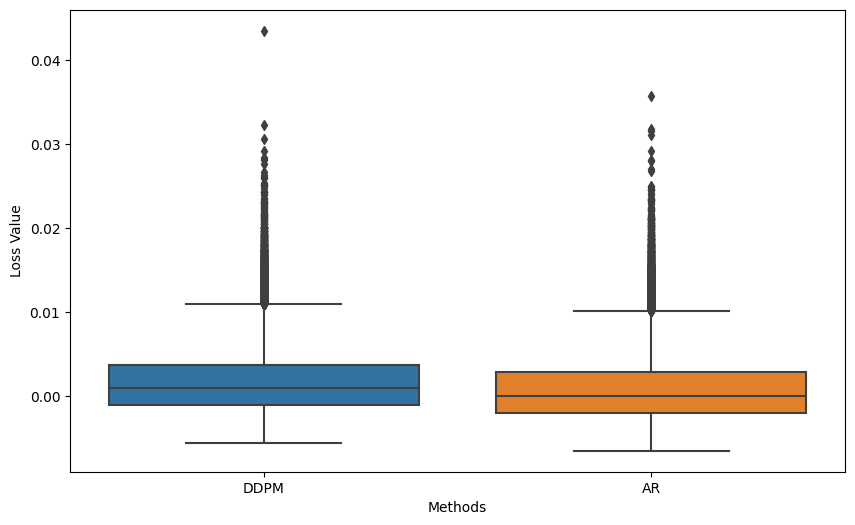

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
k = 1
m = len(df['loss'])//2
loss_estimation_ddpm = df['loss'][m:] - np.mean(list(df['loss'])[-k:])
loss_estimation_ar = df_ar['loss'][m:] - np.mean(list(df_ar['loss'])[-k:])
# loss_estimation_ar_par = df_ar_par['loss'][m:] - np.mean(list(df_ar_par['loss'])[-k:])

# 将数据放入一个DataFrame，并为每个分组指定一个标签
data = {
    'DDPM': list(loss_estimation_ddpm),
    'AR': list(loss_estimation_ar),
    # 'Parallel AR': list(loss_estimation_ar_par)
}

# 创建一个DataFrame
df_box = pd.DataFrame(data)

# First, reshape the data to a long-form DataFrame
df_box_long = pd.melt(df_box, value_vars=['DDPM', 'AR'],
                      var_name='Methods', value_name='Loss Value')
# df_box_long = pd.melt(df_box, value_vars=['DDPM', 'AR', 'Parallel AR'],
#                       var_name='Methods', value_name='Loss Value')

# Create the boxplot with the specified whis range
plt.figure(figsize=(10, 6))
sns.boxplot(x='Methods', y='Loss Value', data=df_box_long)

# Set title and labels
# plt.title('Boxplot Comparison of Loss Estimations and Differences')
# plt.xlabel('Methods')
# plt.ylabel('Loss Value')

# Show plot
plt.show()


In [12]:
loss_difference = loss_estimation_ddpm - loss_estimation_ar
positive_percentage = (loss_difference > 0).mean() * 100
print("DDPM - AR:",positive_percentage,np.mean(loss_difference))
# loss_difference_par = loss_estimation_ar_par - loss_estimation_ar
# positive_percentage = (loss_difference_par > 0).mean() * 100
# print("AR_Parallel - AR:",positive_percentage,np.median(loss_difference_par))
# loss_difference = loss_estimation_ddpm - loss_estimation_ar_par
# positive_percentage = (loss_difference > 0).mean() * 100
# print("DDPM - AR_Parallel:",positive_percentage,np.mean(loss_difference))

DDPM - AR: 57.85187437001008 0.0009205132866148888


/tmp/ipykernel_3503792/3143356932.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0%}'.format(x) for x in current_ticks])


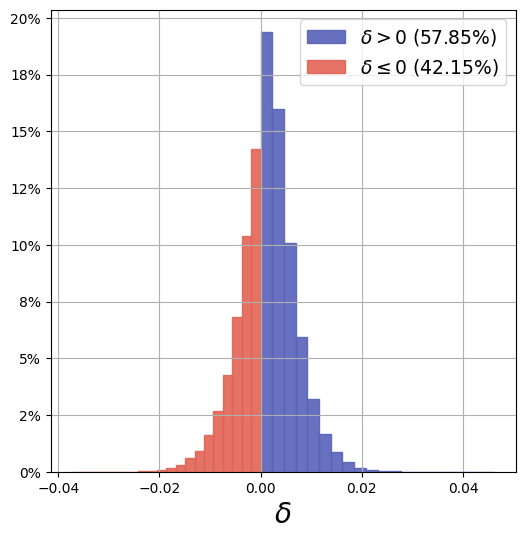

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os  # 新增路径管理模块

# 假设 loss_difference 是已定义好的数据
positive_loss_difference = loss_difference[loss_difference > 0]
negative_loss_difference = loss_difference[loss_difference <= 0]
ratio_positve = round((loss_difference > 0).mean() * 100,2)
ratio_negative = round((loss_difference <=0).mean() * 100,2)
# 计算总样本数（正负样本之和）
total_samples = len(loss_difference)

plt.figure(figsize=(6, 6))
colors = ['#5762b8', '#E26354']

# 设置输出路径
output_dir = "/cpfs04/user/hanyujin/causal-dm/ar_ddpm"
output_filename = os.path.join(output_dir, "task1_loss_distribution.pdf")

# 创建目标目录（自动处理路径不存在的情况）
os.makedirs(output_dir, exist_ok=True)  # 关键路径管理操作（参考网页4）

# 绘制正样本比率直方图
plt.hist(
    positive_loss_difference,
    bins=20,
    weights=np.ones_like(positive_loss_difference)/total_samples,
    color=colors[0],
    edgecolor=colors[0],
    alpha=0.9,
    label=f'$\delta > 0$ ({ratio_positve}%)'
)

# 绘制负样本比率直方图
plt.hist(
    negative_loss_difference,
    bins=20,
    weights=np.ones_like(negative_loss_difference)/total_samples,
    color=colors[1],
    edgecolor=colors[1],
    alpha=0.9,
    label=f'$\delta \leq 0$ ({ratio_negative}%)'
)

# 设置标签
plt.xlabel(f'$\delta$',fontsize = 20)
# plt.ylabel('Proportion',fontsize = 20)
plt.grid(True)
plt.legend(fontsize=13.5)

# 设置百分比刻度
current_ticks = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0%}'.format(x) for x in current_ticks])

# 保存PDF文件（核心输出功能）
plt.savefig(
    output_filename,
    format='pdf',  # 指定PDF格式（参考网页1）
    bbox_inches='tight',  # 防止图像裁剪（参考网页4）
    dpi=300,  # 设置打印级分辨率
    pad_inches=0.1  # 增加边缘留白
)

plt.show()  # 保持原显示功能

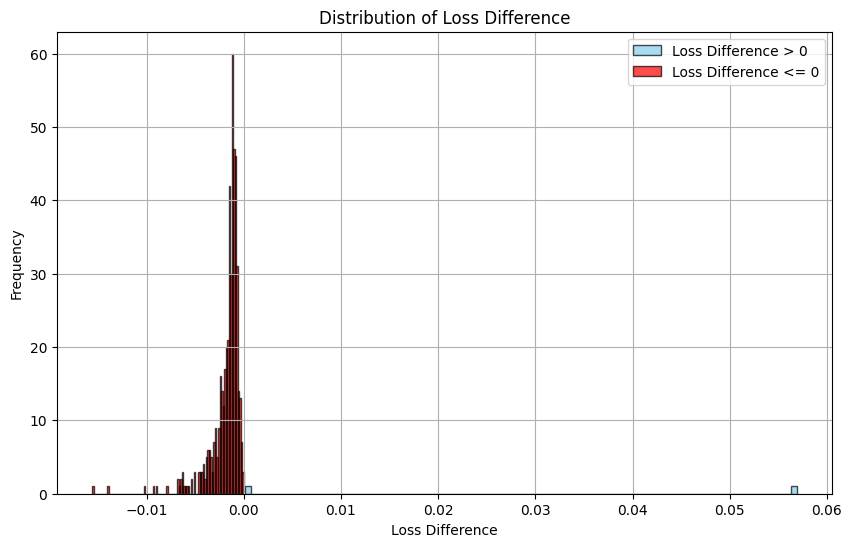

In [76]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设loss_difference已经计算好
# 分别提取大于0和小于0的部分
positive_loss_difference = loss_difference_par[loss_difference_par > 0]
negative_loss_difference = loss_difference_par[loss_difference_par <= 0]
plt.figure(figsize=(10, 6))
plt.hist(positive_loss_difference, bins=100, color='skyblue', edgecolor='black', alpha=0.7, label='Loss Difference > 0')
plt.hist(negative_loss_difference, bins=100, color='red', edgecolor='black', alpha=0.7, label='Loss Difference <= 0')
plt.xlabel('Loss Difference')
plt.ylabel('Frequency')
plt.title('Distribution of Loss Difference')
plt.legend()
plt.grid(True)
plt.show()


## Square

In [12]:
import wandb

api = wandb.Api()
run = api.run("yujinhan-the-university-of-hong-kong/autoregressive-diffusion/runs/xs8gtspq")

# history = run.scan_history(keys=["_step", "loss"])
history = run.scan_history(keys=["_step", "loss","single_loss"])


import pandas as pd
data = pd.DataFrame(history)

data.to_csv("/cpfs04/user/hanyujin/causal-dm/AR_diff/loss/square_ar8.csv", index=False)


True


Calculating variance: 100%|██████████| 250/250 [00:00<00:00, 14055.60it/s]
/tmp/ipykernel_3622691/1050108738.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


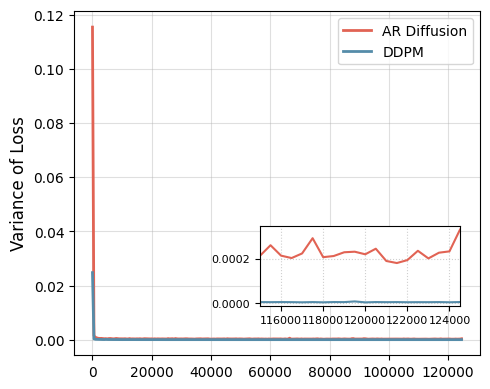

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
group_size = 250

file_path = "/cpfs04/user/hanyujin/causal-dm/AR_diff/loss/square_ddpm.csv"
df = pd.read_csv(file_path)
df = df[['_step', 'loss']]
leng = len(df)
# df['group'] = (df.index // group_size)
# df = df.groupby('group').agg({'_step': 'first', 'loss': 'mean'}).reset_index(drop=True)


file_path = "/cpfs04/user/hanyujin/causal-dm/AR_diff/loss/square_ar8.csv"
df_ar = pd.read_csv(file_path)
df_ar = df_ar[['_step', 'loss']]
df_ar = df_ar.iloc[:leng, :]
df_ar['_step'] = df_ar['_step']  - 1
# df_ar['group'] = (df_ar.index // group_size)
# df_ar = df_ar.groupby('group').agg({'_step': 'first', 'loss': 'mean'}).reset_index(drop=True)




# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from tqdm import tqdm
# from matplotlib import font_manager as fm
# import os

# # 设置 Times New Roman 字体
# # times_new_roman_path = "/usr/share/fonts/truetype/msttcorefonts/times.ttf"
# # if os.path.exists(times_new_roman_path):
# #     fm.fontManager.addfont(times_new_roman_path)
# #     plt.rcParams['font.family'] = 'Times New Roman'

# # ---------------------- 数据加载部分保持不变 ----------------------
# group_size = 250

# file_path = "/cpfs04/user/hanyujin/causal-dm/AR_diff/loss/shadow_ddpm.csv"
# df = pd.read_csv(file_path)
# df = df[['_step', 'loss']]
# leng = len(df)

# file_path = "/cpfs04/user/hanyujin/causal-dm/AR_diff/loss/shadow_ar16.csv"
# df_ar = pd.read_csv(file_path)
# df_ar = df_ar[['_step', 'loss']]
# df_ar = df_ar.iloc[:leng, :]
# df_ar['_step'] = df_ar['_step'] - 1

# file_path = "/cpfs04/user/hanyujin/causal-dm/AR_diff/loss/shadow_ar16_parallel.csv"
# df_ar_par = pd.read_csv(file_path)
# df_ar_par = df_ar_par[['_step', 'loss']]
# df_ar_par = df_ar_par.iloc[:leng, :]
# df_ar_par['_step'] = df_ar_par['_step'] - 1

def calculate_loss_variance(df, k):
    variances = []
    for i in tqdm(range(0, len(df) - k + 1, k), desc="Calculating variance"):
        window_loss = df['loss'].iloc[i:i+k]
        variance = np.var(window_loss)
        variances.append(variance)
    return variances, df['_step'].iloc[::k].values

k = 500
variances, steps = calculate_loss_variance(df, k)
variances_ar, steps_ar = calculate_loss_variance(df_ar, k)
# variances_ar_par, steps_ar_par = calculate_loss_variance(df_ar_par, k)  # 注意这里应该使用 df_ar_par

# ---------------------- 绘图部分修改 ----------------------
# 创建复合图形布局
plt.figure(figsize=(5, 4))
# gs = fig.add_gridspec(  1, 1, height_ratios=[3, 1], hspace=0.15)

# 主图设置
# plt.add_subplot(gs[0])
plt.plot(steps_ar, variances_ar, label='AR Diffusion', color='#e16354', linewidth=2)
plt.plot(steps, variances, label='DDPM', color='#558ca9', linewidth=2)
# plt.plot(steps_ar, variances_ar, label='AR Diffusion', color='#e16354', linewidth=2)
# ax_main.plot(steps_ar_par, variances_ar_par, '--', 
#             label='AR Parallel', color='#fea443', linewidth=2)

plt.ylabel('Variance of Loss', fontsize=12)
plt.legend(fontsize=10, loc='upper right')
plt.grid(True, alpha=0.4)
plt.tick_params(axis='both', labelsize=10)

# 子图设置（最后500窗口的细节）
# ax_zoom = fig.add_subplot(gs[1])
zoom_window = 20  # 需要放大的窗口数

# 截取最后500个窗口的数据
def get_last_n_data(data, steps, n):
    return data[-n:], steps[-n:]

zoom_var, zoom_steps = get_last_n_data(variances, steps, zoom_window)
zoom_var_ar, zoom_steps_ar = get_last_n_data(variances_ar, steps_ar, zoom_window)
# zoom_var_par, zoom_steps_par = get_last_n_data(variances_ar_par, steps_ar_par, zoom_window)
left, bottom, width, height = [0.53, 0.22, 0.4, 0.2] 
ax_zoom = plt.axes([left, bottom, width, height]) 
# 绘制子图
ax_zoom.plot(zoom_steps_ar, zoom_var_ar, color='#e16354', linewidth=1.5)
ax_zoom.plot(zoom_steps, zoom_var, color='#558ca9', linewidth=1.5)
# ax_zoom.plot(zoom_steps_ar, zoom_var_ar, color='#e16354', linewidth=1.5)
# ax_zoom.plot(zoom_steps_par, zoom_var_par, '--', color='#fea443', linewidth=1.5)

# 子图标注设置
# ax_zoom.set_xlabel('Window Start Step', fontsize=12)
# ax_zoom.set_ylabel('Variance', fontsize=10)
ax_zoom.grid(True, linestyle=':', alpha=0.6)
ax_zoom.tick_params(axis='both', labelsize=8)

# 自动调整坐标范围
zoom_start = min(zoom_steps[0], zoom_steps_ar[0])
zoom_end = max(zoom_steps[-1], zoom_steps_ar[-1])
ax_zoom.set_xlim(zoom_start, zoom_end)

# 保存图片
output_path = "/cpfs04/user/hanyujin/causal-dm/ar_ddpm/task2_variance.pdf"
plt.tight_layout()
plt.savefig(output_path, format='pdf', bbox_inches='tight', dpi=300)
plt.show()

In [15]:
loss_estimation_ddpm

62500    -0.002888
62501    -0.003650
62502    -0.002815
62503    -0.001471
62504    -0.003766
            ...   
124995   -0.002647
124996   -0.003404
124997   -0.003281
124998   -0.001544
124999    0.000000
Name: loss, Length: 62500, dtype: float64

In [3]:
loss_estimation_ar

62500    -0.005217
62501    -0.006597
62502    -0.008673
62503    -0.004139
62504    -0.003420
            ...   
124995   -0.008639
124996   -0.001655
124997   -0.005792
124998   -0.005716
124999    0.000000
Name: loss, Length: 62500, dtype: float64

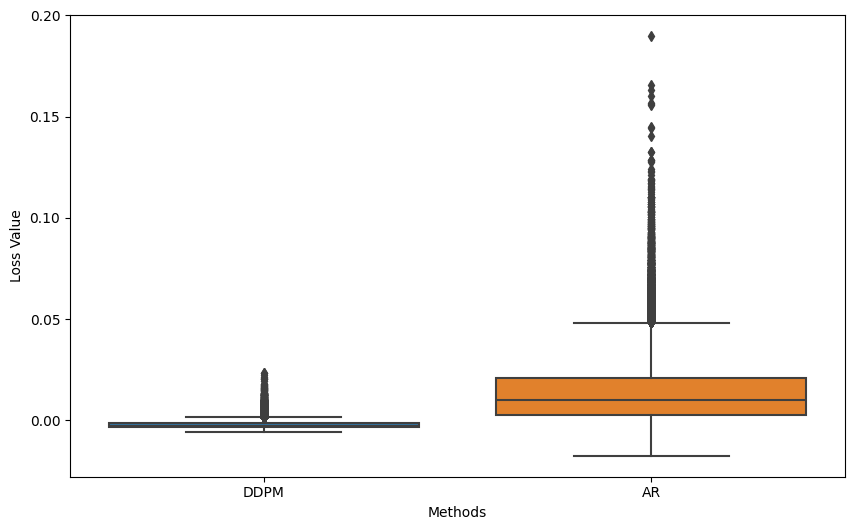

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
k = 1
m = len(df['loss'])//2
loss_estimation_ddpm = df['loss'][m:] - np.mean(list(df['loss'])[-k:])
loss_estimation_ar = df_ar['loss'][m:] - np.mean(list(df_ar['loss'])[-k:])

data = {
    'DDPM': list(loss_estimation_ddpm),
    'AR': list(loss_estimation_ar)
}

# 创建一个DataFrame
df_box = pd.DataFrame(data)

# First, reshape the data to a long-form DataFrame
df_box_long = pd.melt(df_box, value_vars=['DDPM', 'AR'],
                      var_name='Methods', value_name='Loss Value')

# Create the boxplot with the specified whis range
plt.figure(figsize=(10, 6))
sns.boxplot(x='Methods', y='Loss Value', data=df_box_long)

# Set title and labels
# plt.title('Boxplot Comparison of Loss Estimations and Differences')
# plt.xlabel('Methods')
# plt.ylabel('Loss Value')

# Show plot
plt.show()


In [17]:
loss_difference = loss_estimation_ddpm - loss_estimation_ar
positive_percentage = (loss_difference >= 0).mean() * 100
print("DDPM - AR:",positive_percentage,np.mean(loss_difference))

DDPM - AR: 12.192 -0.015522634567394937


/tmp/ipykernel_3622691/1388340219.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0%}'.format(x) for x in current_ticks])


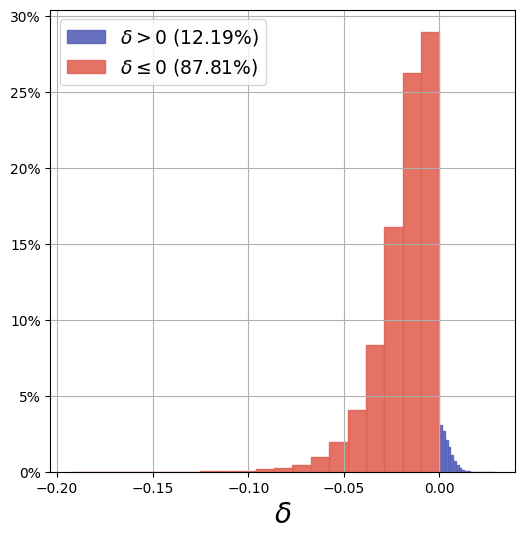

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os  # 新增路径管理模块

# 假设 loss_difference 是已定义好的数据
positive_loss_difference = loss_difference[loss_difference > 0]
negative_loss_difference = loss_difference[loss_difference <= 0]
ratio_positve = round((loss_difference > 0).mean() * 100,2)
ratio_negative = round((loss_difference <=0).mean() * 100,2)
# 计算总样本数（正负样本之和）
total_samples = len(loss_difference)

plt.figure(figsize=(6, 6))
colors = ['#5762b8', '#E26354']

# 设置输出路径
output_dir = "/cpfs04/user/hanyujin/causal-dm/ar_ddpm"
output_filename = os.path.join(output_dir, "task2_loss_distribution.pdf")

# 创建目标目录（自动处理路径不存在的情况）
os.makedirs(output_dir, exist_ok=True)  # 关键路径管理操作（参考网页4）

# 绘制正样本比率直方图
plt.hist(
    positive_loss_difference,
    bins=20,
    weights=np.ones_like(positive_loss_difference)/total_samples,
    color=colors[0],
    edgecolor=colors[0],
    alpha=0.9,
    label=f'$\delta > 0$ ({ratio_positve}%)'
)

# 绘制负样本比率直方图
plt.hist(
    negative_loss_difference,
    bins=20,
    weights=np.ones_like(negative_loss_difference)/total_samples,
    color=colors[1],
    edgecolor=colors[1],
    alpha=0.9,
    label=f'$\delta \leq 0$ ({ratio_negative}%)'
)

# 设置标签
plt.xlabel(f'$\delta$',fontsize = 20)
# plt.ylabel('Proportion',fontsize = 20)
plt.grid(True)
plt.legend(fontsize=13.5)

# 设置百分比刻度
current_ticks = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0%}'.format(x) for x in current_ticks])

# 保存PDF文件（核心输出功能）
plt.savefig(
    output_filename,
    format='pdf',  # 指定PDF格式（参考网页1）
    bbox_inches='tight',  # 防止图像裁剪（参考网页4）
    dpi=300,  # 设置打印级分辨率
    pad_inches=0.1  # 增加边缘留白
)

plt.show()  # 保持原显示功能

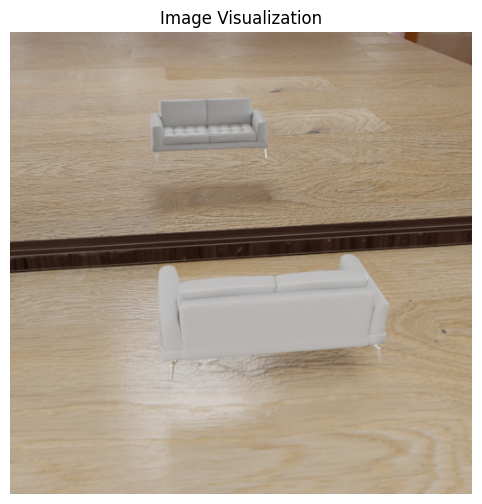

In [16]:
import h5py
import json
import numpy as np

def extract_data_from_hdf5(hdf5_path: str):
    """returns the data present in the hdf5_path file"""

    hdf5_data = h5py.File(hdf5_path, "r")

    data = {
        "image": np.array(hdf5_data["colors"], dtype=np.uint8),
        "mask": (np.array(hdf5_data["category_id_segmaps"], dtype=np.uint8) == 1).astype(np.uint8) * 255, # mask containing the mirror region
        "object_mask": (np.array(hdf5_data["category_id_segmaps"], dtype=np.uint8) == 2).astype(np.uint8) * 255, # mask depicting the object
        "depth": np.array(hdf5_data["depth"]),
        "normals": np.array(hdf5_data["normals"]),
        "cam_states": np.array(hdf5_data["cam_states"]),
    }

    return data

def decode_cam_states(cam_states):
    """return cam2world, cam_K matrices used to render the image from data["cam_states"], both as lists. The blender convention is followed.
    """
    array = np.array(cam_states)
    json_str = array.tobytes().decode("utf-8")
    data = json.loads(json_str)
    cam2world = data["cam2world"]
    cam_K = data["cam_K"]
    return cam2world, cam_K

import matplotlib.pyplot as plt

# 假设你已经用 extract_data_from_hdf5 函数加载了数据
data = extract_data_from_hdf5("/cpfs04/user/hanyujin/rule-gen/datasets/extracted_batch_1/abo_v3/4/B07G2HBKB4/2.hdf5")
image = data["image"]

plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.title("Image Visualization")
plt.axis("off")  # 不显示坐标轴
plt.show()
